In [16]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from scipy import stats
# import carbon_utils
# import PyCO2SYS as pyco2
from tabulate import tabulate
from io import StringIO  # for creating a string buffer to store the table
from multiprocessing import Pool
import functions.pressure_level_glodap_mean as pl
# from datetime import datetime
import functions.plot_offsets_crossover_plot_only as plot_gdap
import time
import functions.outlier_filter_ESD_test as outlier


### Set up paths

In [28]:
adjustment=False
# glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_offsets_filename = 'glodap_offsets_100km_2_to_50_50m_0.1dens_0.1spice_5.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]

if adjustment is True:
    argo_path = argo_path + '../Corrected/Sprof/'

# Set the paths
# for deep o2 manuscript:
output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'
# output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_LIPHR_14/'

# output_dir = argo_path + '../output_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14/'
output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'
# output_dir = argo_path + '../output_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'

data_dir = 'data/'

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)
# if not os.path.isdir(grouped_plot_dir):
#     os.mkdir(grouped_plot_dir)


# inputs that will not normally change
var_list_plot = ['PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED','DOXY_ADJUSTED','NITRATE_ADJUSTED',
                    'DIC','pH_25C_TOTAL_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED','PDENS']


### Identify files, pressure levels, float age bins

In [29]:
# user inputs
# calculate trimmed means at different pressure levels for listed files
grouped_plot_dir = offset_dir + '2024_10_22/'
# grouped_plot_dir = offset_dir + '2024_09_25/'

# todays_date = datetime.today().strftime('%Y_%m_%d')
# grouped_plot_dir = offset_dir + 'grouped_plots/' + todays_date + '/'

# grouped_plot_dir = offset_dir + 'grouped_plots/levels_mean_saved/'

if not os.path.isdir(grouped_plot_dir):
    os.mkdir(grouped_plot_dir)

# for manuscript:
glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']

# glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_6.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05_spice_7.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_LIPHR_7.nc']
# glodap_offsets_filenames = ['output_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc', 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc','glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_500_25m_0.05dens_0.05spice_ESPER_14.nc','glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']

pressure_levels = [1500, 2000]  # Adjust as needed
# pressure_levels = [0, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed
# pressure_levels = [1500, 2000]  # Adjust as needed
# pressure_levels = [1, 50]  # Adjust as needed

# pressure_levels = [1500, 1700, 2000]  # Adjust as needed

year_filt = 0
year_plus_minus = 5

# bin edges in days to calculat mean offset as it evolves over the float/optode's age
# float_age_bins = [0, 365/2, 365, 365*2, 365*3, 365*7]
# float_age_bins = [0, 365, 365*7]
float_age_bins = [0, 365*10]



### prepare the list of arguments to pass to pressure_level_filter


In [30]:
glodap_offsets = []
delay_between_starts = 5  # number of seconds for each additional instance to wait, may help with a memory bottleneck 

for filename in glodap_offsets_filenames:
        ds = xr.load_dataset(argo_path + '../output_' + filename[15:-3] + '/' +filename)
        # ds = xr.load_dataset(output_dir+filename)
        glodap_offsets.append(ds)

gdap_mean_args = []
for idx, gdap_offsets_n in enumerate(glodap_offsets):
        time_delay = 0
        gdap_offsets_n_temp = gdap_offsets_n.copy()
        for j in range(len(pressure_levels) - 1):
                # only add to the processing list if the pressure level is in the correct range for a given file, otherwise skip 
                if np.logical_and(np.nanmin(gdap_offsets_n_temp.PRES_ADJUSTED_float)<= pressure_levels[j+1], np.nanmax(gdap_offsets_n_temp.PRES_ADJUSTED_float)>= pressure_levels[j]):
                        print(idx)
                        print(pressure_levels[j])
                        time_delay = time_delay+ delay_between_starts
                        gdap_mean_args_n = [(argo_path,grouped_plot_dir,
                                glodap_offsets_filenames[idx][0:-3],
                                gdap_offsets_n_temp, 
                                var_list_plot,year_filt,pressure_levels[j],
                                pressure_levels[j+1],year_plus_minus,time_delay, float_age_bins) ]
                        gdap_mean_args.extend(gdap_mean_args_n)
                # break   
        # break
print(len(gdap_mean_args))

0
1500
1


### run pressure level filter for all files, all pressures 


In [24]:
num_processes = 18 # number of cpus to use 

if __name__ == "__main__":
    
    with Pool(processes=num_processes) as pool:
        # Use pool.starmap with the list of arguments
        pool.starmap(pl.pressure_level_filter, gdap_mean_args)

H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 1
1
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/op

0 out of 186
1 out of 186
2 out of 186
3 out of 186
4 out of 186
5 out of 186
6 out of 186
7 out of 186
8 out of 186
9 out of 186
10 out of 186
11 out of 186
12 out of 186
13 out of 186
14 out of 186
15 out of 186
16 out of 186
17 out of 186
18 out of 186
19 out of 186
20 out of 186
21 out of 186
22 out of 186
23 out of 186
24 out of 186
25 out of 186
26 out of 186
27 out of 186
28 out of 186
29 out of 186
30 out of 186
31 out of 186
32 out of 186
33 out of 186
34 out of 186
35 out of 186
36 out of 186
37 out of 186
38 out of 186
39 out of 186
40 out of 186
41 out of 186
42 out of 186
43 out of 186
44 out of 186
45 out of 186
46 out of 186
47 out of 186
48 out of 186
49 out of 186
50 out of 186
51 out of 186
52 out of 186
53 out of 186
54 out of 186
55 out of 186
56 out of 186
57 out of 186
58 out of 186
59 out of 186
60 out of 186
61 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


62 out of 186
63 out of 186
64 out of 186
65 out of 186
66 out of 186
67 out of 186
68 out of 186
69 out of 186
70 out of 186
71 out of 186
72 out of 186
73 out of 186
74 out of 186
75 out of 186
76 out of 186
77 out of 186
78 out of 186
79 out of 186
80 out of 186
81 out of 186
82 out of 186
83 out of 186
84 out of 186
85 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


86 out of 186
87 out of 186
88 out of 186
89 out of 186
90 out of 186
91 out of 186
92 out of 186
93 out of 186
94 out of 186
95 out of 186
96 out of 186
97 out of 186
98 out of 186
99 out of 186
100 out of 186
101 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


102 out of 186
103 out of 186
104 out of 186
105 out of 186
106 out of 186
107 out of 186
108 out of 186
109 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


110 out of 186
111 out of 186
112 out of 186
113 out of 186
114 out of 186
115 out of 186
116 out of 186
117 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


118 out of 186
119 out of 186
120 out of 186
121 out of 186
122 out of 186
123 out of 186
124 out of 186
125 out of 186
126 out of 186
127 out of 186
128 out of 186
129 out of 186
130 out of 186
131 out of 186
132 out of 186
133 out of 186
134 out of 186
135 out of 186
136 out of 186
137 out of 186
138 out of 186
139 out of 186
140 out of 186
141 out of 186
142 out of 186
143 out of 186
144 out of 186
145 out of 186
146 out of 186
147 out of 186
148 out of 186
149 out of 186
150 out of 186
151 out of 186
152 out of 186
153 out of 186
154 out of 186
155 out of 186
156 out of 186
157 out of 186
158 out of 186
159 out of 186
160 out of 186
161 out of 186
162 out of 186
163 out of 186
164 out of 186
165 out of 186
166 out of 186
167 out of 186
168 out of 186
169 out of 186
170 out of 186
171 out of 186
172 out of 186
173 out of 186
174 out of 186
175 out of 186
176 out of 186
177 out of 186
178 out of 186
179 out of 186
180 out of 186
181 out of 186
multiple cal comments
6903575
182 out of

### Take netcdf output of crossovers and load all into gdap_offsets and mean_gdap_offsets

In [31]:
# put all .nc files into grouped arrays 


mean_gdap_offsets = {}
gdap_offsets = {}
# load .nc files saved out for pressure levels
for idx, filename in enumerate(glodap_offsets_filenames):

        trimmed_means = {}
        # variables with offsets that you want to trim

        gdap_offsets_file = {}
        for j in range(len(pressure_levels) - 1):
                pressure_level_min = pressure_levels[j]
                nc_filename_mean = grouped_plot_dir+filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                
                
                try:
                        ds = xr.load_dataset(nc_filename_mean)
                except:
                        continue
                trimmed_means[f'level_{pressure_levels[j]}'] = ds
                
                nc_filename_all = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                all_offsets_ds = xr.load_dataset(nc_filename_all)
                gdap_offsets_file[f'level_{pressure_levels[j]}'] = all_offsets_ds
                # break
        mean_gdap_offsets[glodap_offsets_filenames[idx]]=trimmed_means
        gdap_offsets[glodap_offsets_filenames[idx]]=gdap_offsets_file
        # break


### Plot individual crossover plots

In [27]:
# For making individual plots
from importlib import reload

parallel_on = True
reload(plot_gdap)
num_processes = 18 # number of cpus to use 

# make individual glodap crossover plots for each pressure level
# filename = 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc'
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):
        pressure_level_min = pressure_levels[j]
        pressure_level_max = pressure_levels[j+1]

        # single_level_offsets = gdap_offsets[filename]['level_1500']
        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue
        individual_plot_dir = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + \
                                                    '_level_' + str(pressure_level_min) + '_individual_floats/'
        if not os.path.isdir(individual_plot_dir):
            os.mkdir(individual_plot_dir)
            
        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        print(individual_plot_dir)
        
        if parallel_on is False:
            if 'checklist' not in locals():
                unique_labels = list(offsets_g.groups.keys())
                checklist = [False] * len(unique_labels)

            print(unique_labels)
        
            for n, g in offsets_g:
                
                index_to_check = unique_labels.index(n)

                # print(checklist[index_to_check])
                if not checklist[index_to_check]:
                    plot_gdap.plot_glodap_crossovers(individual_plot_dir,
                                mean_level_offsets,
                                g, [pressure_level_min, pressure_level_max], float_age_bins)
                    
                    # Find the index of the label in unique_labels
                    index_to_mark_off = unique_labels.index(n)
                    
                    # Mark off the corresponding position in the checklist
                    checklist[index_to_mark_off] = True
                    break
        else:
            if __name__ == "__main__":
                
                with Pool(processes=num_processes) as pool:
                    # Create a list of arguments for pool.starmap
                    gdap_cross_plot_args = [(individual_plot_dir,
                            mean_level_offsets,
                            g, [pressure_level_min, pressure_level_max], float_age_bins) for n, g in offsets_g]
                    # print('Here')
                    # Use pool.starmap with the list of arguments
                    pool.starmap(plot_gdap.plot_glodap_crossovers, gdap_cross_plot_args)
        # break



/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Datasets/Data_Products/BGC_ARGO_GLOBAL/2024_07_09/Sprof/../output_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14/glodap_offset_plots/2024_09_25/glodap_offsets_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14_all_offsets_depth_grouped_year_filt_0_5_level_1_individual_floats/
Here
Plotting crossover for: 3901065
Plotting crossover for: 1901206
Plotting crossover for: 2900127Plotting crossover for: 4900874

Plotting crossover for: 1902644
Plotting crossover for: 1900943
Plotting crossover for: 5901460
Plotting crossover for: 4901805
Plotting crossover for: 1901338
Plotting crossover for: 4900477
Plotting crossover for: 5901046
Plotting crossover for: 2903615
Plotting crossover for: 3902129
Plotting crossover for: 2903354
Plotting crossover for: 3900333
Plotting crossover for: 3901084
Plotting crossover for: 5901311
Plotting crossover for: 5901446
No non-nan DOXY offsets
Plotting crossover for: 2900114
No non-nan DOXY offsets
Plotting crossover for: 1901

/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903451
Plotting crossover for: 3901496
Plotting crossover for: 3902132
Plotting crossover for: 5901313
Plotting crossover for: 3901066
Plotting crossover for: 5901049
No non-nan DOXY offsets
Plotting crossover for: 5901051
No non-nan DOXY offsets
Plotting crossover for: 5901052
Plotting crossover for: 2903648
Plotting crossover for: 3900334
Plotting crossover for: 5901461


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 1901135
Plotting crossover for: 1901208
Plotting crossover for: 5901447
Plotting crossover for: 4900881
Plotting crossover for: 1901339
Plotting crossover for: 4900480
No non-nan DOXY offsets
Plotting crossover for: 4900481
Plotting crossover for: 2900115
Plotting crossover for: 4903026
Plotting crossover for: 2900128


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903454
Plotting crossover for: 3901497


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 3902462
Plotting crossover for: 4900482
No non-nan DOXY offsets
Plotting crossover for: 4900483
Plotting crossover for: 2903650
Plotting crossover for: 5901069
No non-nan DOXY offsets
Plotting crossover for: 5901071
Plotting crossover for: 3900348
Plotting crossover for: 2900129
Plotting crossover for: 3901067
Plotting crossover for: 5901314
-99.93493663646423
0.00613567959894044
Plotting crossover for: 1901348
Plotting crossover for: 1901152
Plotting crossover for: 2900116
Plotting crossover for: 1901209


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901465
Plotting crossover for: 5901448
-80440.50669245732
4.773752755281974
Plotting crossover for: 4903587
No non-nan DOXY offsets
Plotting crossover for: 4903591
Plotting crossover for: 4900882


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903457
Plotting crossover for: 3901498


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 3902463
Plotting crossover for: 5901072
Plotting crossover for: 2903651
Plotting crossover for: 4900485
Plotting crossover for: 3900515


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901336
Plotting crossover for: 3901068
Plotting crossover for: 1901360
Plotting crossover for: 5901449
Plotting crossover for: 1901153
No non-nan DOXY offsets
Plotting crossover for: 1901154
Plotting crossover for: 5901466
Plotting crossover for: 1901210
Plotting crossover for: 4903622
Plotting crossover for: 2900765


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

15.22719393514631
-0.0016013597744512944
Plotting crossover for: 2900117
Plotting crossover for: 4901137


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903458
Plotting crossover for: 3901530


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, na

Plotting crossover for: 3902464


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901073
No non-nan DOXY offsets
Plotting crossover for: 5901178
Plotting crossover for: 4900487
Plotting crossover for: 2903652
Plotting crossover for: 3900516


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 3901075
No non-nan DOXY offsets
Plotting crossover for: 3901076
Plotting crossover for: 5901450
Plotting crossover for: 5901337
Plotting crossover for: 4903748
No non-nan DOXY offsets
Plotting crossover for: 5900345
Plotting crossover for: 1901361
Plotting crossover for: 5901467
Plotting crossover for: 2902092
Plotting crossover for: 1901155


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/en

Plotting crossover for: 2900118
Plotting crossover for: 1901211


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4901139
Plotting crossover for: 2903462
No non-nan DOXY offsets
Plotting crossover for: 2903467
Plotting crossover for: 3901531
Plotting crossover for: 3902465
Plotting crossover for: 5901187


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4900494
-19.520497990122287
0.0012347313880495623
Plotting crossover for: 2903653
Plotting crossover for: 3900521


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901451
Plotting crossover for: 3901077
Plotting crossover for: 5900841
Plotting crossover for: 5901338
No non-nan DOXY offsets
Plotting crossover for: 5901369
Plotting crossover for: 1901362
Plotting crossover for: 5901468


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2902093
Plotting crossover for: 1901156
Plotting crossover for: 2900119
Plotting crossover for: 1901212


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4901140
Plotting crossover for: 2903470


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 3901668
46.682389681193314
-0.002864671326171326
Plotting crossover for: 3902556
Plotting crossover for: 5901188


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4900497
Plotting crossover for: 2903654
Plotting crossover for: 5901452
Plotting crossover for: 3900523
Plotting crossover for: 3901078


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901370
Plotting crossover for: 5900958
No non-nan DOXY offsets
Plotting crossover for: 5900965
Plotting crossover for: 5901491
Plotting crossover for: 2902270


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 1901363
Plotting crossover for: 1901157
Plotting crossover for: 1901213


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2900120


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903472
Plotting crossover for: 4900093
Plotting crossover for: 5901310


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4901141
15.361499956802549
-0.0011304658597834504
Plotting crossover for: 3901669
18.044374949806837
-0.0009901946836063991
Plotting crossover for: 5901453


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 3901079
Plotting crossover for: 2903656
Plotting crossover for: 4900870
Plotting crossover for: 3900524
Plotting crossover for: 5900966
Plotting crossover for: 5901372


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2902272
Plotting crossover for: 5901492
Plotting crossover for: 1901158
Plotting crossover for: 1901364


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, na

Plotting crossover for: 1901214
Plotting crossover for: 2900123


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903473
No non-nan DOXY offsets
Plotting crossover for: 2903613
Plotting crossover for: 4900345
Plotting crossover for: 5901648


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 4901216
Plotting crossover for: 3902120
Plotting crossover for: 5901454
Plotting crossover for: 3901080


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4900871
12.432963959257801
-0.000536849890426744
Plotting crossover for: 2903657
Plotting crossover for: 5901043
-9.457385477290142
0.00054782361089744
Plotting crossover for: 3900532
Plotting crossover for: 2902294
Plotting crossover for: 5901373


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 1901159
Plotting crossover for: 1901365
Plotting crossover for: 5901644
Plotting crossover for: 1901215
Plotting crossover for: 2900124


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903614
Plotting crossover for: 5901696


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, na

Plotting crossover for: 4900474
Plotting crossover for: 4901784
No non-nan DOXY offsets
Plotting crossover for: 4901801
Plotting crossover for: 3902121
Plotting crossover for: 5901455
-18.90132952078436
0.0017363077503569386


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 3901081


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2903667
Plotting crossover for: 5901741
Plotting crossover for: 1901217
-9.090794988022182
9.350460812556853e-05
Plotting crossover for: 2900125


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4900872
Plotting crossover for: 1901378
22.125419588163872
-0.0022181032052471018
Plotting crossover for: 1901205
Plotting crossover for: 5901645
Plotting crossover for: 5901444
No non-nan DOXY offsets
Plotting crossover for: 5901646
Plotting crossover for: 2902295
No non-nan DOXY offsets
Plotting crossover for: 2902298
Plotting crossover for: 3900728


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902261
Plotting crossover for: 5901699
Plotting crossover for: 4900475


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 3902123
Plotting crossover for: 5901456
No non-nan DOXY offsets
Plotting crossover for: 5901459


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 4901802
Plotting crossover for: 3901082


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 2903869
No non-nan DOXY offsets
Plotting crossover for: 2903886
Plotting crossover for: 5901742


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 2902299
Plotting crossover for: 1902303
Plotting crossover for: 1901218
Plotting crossover for: 5901445
Plotting crossover for: 5902305
13.84082064719652
-0.0009963953686382568
Plotting crossover for: 5901647


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 2900126
Plotting crossover for: 5903259
Plotting crossover for: 5902267
Plotting crossover for: 3900729
Plotting crossover for: 5901730
Plotting crossover for: 4900476


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903594
Plotting crossover for: 3902124
Plotting crossover for: 5903713


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/sokal_rohlf_calculations.py:63: RuntimeWarning: invalid value encountered in double_scalars
  r2 = s2_y_hat/s2_Y
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:1

-167.59683838772995
0.016368678991913105
Plotting crossover for: 4901803


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903755
Plotting crossover for: 5901743
Plotting crossover for: 1902304


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902306
Plotting crossover for: 5904024
Plotting crossover for: 5904036
37.76783731501542
-0.0025152655396569997
Plotting crossover for: 5904125
41.7642105569999
-0.00420813199595154


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903260
Plotting crossover for: 5902269
Plotting crossover for: 5904183


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 1901329
Plotting crossover for: 3900792
Plotting crossover for: 5901731
Plotting crossover for: 5903611


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904469
-18.472073269209954
0.0010852535767367708
Plotting crossover for: 5904482
Plotting crossover for: 5904658
Plotting crossover for: 5903714


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

9.986840701631008
-0.0010166147000988013
Plotting crossover for: 5903887
3.118304348980189
-0.0009751946680112378


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901744
Plotting crossover for: 5904025
Plotting crossover for: 5904089
Plotting crossover for: 5902307
Plotting crossover for: 5904673
Plotting crossover for: 5903264


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904126
Plotting crossover for: 5904184
No non-nan DOXY offsets
Plotting crossover for: 5904185
Plotting crossover for: 5902295
Plotting crossover for: 5904687
Plotting crossover for: 5904767


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901733
Plotting crossover for: 5903612
Plotting crossover for: 5904483


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904659
Plotting crossover for: 5904470
Plotting crossover for: 5903717


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903888
Plotting crossover for: 5902100
No non-nan DOXY offsets
Plotting crossover for: 5902105
Plotting crossover for: 5902308
Plotting crossover for: 5904026
Plotting crossover for: 5904090
Plotting crossover for: 5904674


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903272
Plotting crossover for: 5904186
Plotting crossover for: 5904145


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904689
Plotting crossover for: 5902297
Plotting crossover for: 5904768
No non-nan DOXY offsets
Plotting crossover for: 5904769
Plotting crossover for: 5901734
Plotting crossover for: 5903613
Plotting crossover for: 5904484


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904471
Plotting crossover for: 5904660
76.79484652508472
-0.010142945391491388


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903718
No non-nan DOXY offsets
Plotting crossover for: 5903719
Plotting crossover for: 5903889


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902109
Plotting crossover for: 5904027


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5903225
Plotting crossover for: 5904675
Plotting crossover for: 5904091


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904187
Plotting crossover for: 5903274
Plotting crossover for: 5904147
2.6683194283090907
1.1954391114687445e-05
Plotting crossover for: 5904690
Plotting crossover for: 5902298


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904485
Plotting crossover for: 5903614
Plotting crossover for: 5901735
Plotting crossover for: 5904841
Plotting crossover for: 5904661


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903720
Plotting crossover for: 5904472
Plotting crossover for: 5903890


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902110
Plotting crossover for: 5904028
Plotting crossover for: 5903226
Plotting crossover for: 5904092


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904676
Plotting crossover for: 5904165


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904691
Plotting crossover for: 5902299
Plotting crossover for: 5903377
Plotting crossover for: 5904487
Plotting crossover for: 5901736
Plotting crossover for: 5903615


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

-0.5923860192794308
-0.002691868561074883
Plotting crossover for: 5904842
Plotting crossover for: 5904662


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904473
No non-nan DOXY offsets
Plotting crossover for: 5904474
Plotting crossover for: 5903721
Plotting crossover for: 5903891
Plotting crossover for: 5904188


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902112


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904093
Plotting crossover for: 5903242
Plotting crossover for: 5904029
9.706119693406235
-0.0005873440479636938
Plotting crossover for: 5904677


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904166
-20875.046528918414
2.1050236526641277
Plotting crossover for: 5904692
Plotting crossover for: 5902300
Plotting crossover for: 5903381
No non-nan DOXY offsets
Plotting crossover for: 5903385


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5901737
Plotting crossover for: 5904598


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904843
No non-nan DOXY offsets
Plotting crossover for: 5904844
Plotting crossover for: 5904663
Plotting crossover for: 5903616
43.1998885384348
-0.005900784872907941
Plotting crossover for: 5903892
Plotting crossover for: 5903722
Plotting crossover for: 5904475


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904220
Plotting crossover for: 5902113


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903248
Plotting crossover for: 5904095
37.3735933975174
-0.002776239310475614
Plotting crossover for: 5904030


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904678
Plotting crossover for: 5904693


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5902301
Plotting crossover for: 5904167
Plotting crossover for: 5903405
Plotting crossover for: 5904599
nan
nan
-18.75892109071494
0.001637515316748464
Plotting crossover for: 5901739


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904665
Plotting crossover for: 5904845


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903893
Plotting crossover for: 5903724
-22.060027350524308
0.00010366139093061669


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904395
No non-nan DOXY offsets
Plotting crossover for: 5904396
Plotting crossover for: 5904476
Plotting crossover for: 5902116
Plotting crossover for: 5903649
Plotting crossover for: 5903255


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904104


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904679
Plotting crossover for: 5904031
Plotting crossover for: 5904694
Plotting crossover for: 5902302


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904600
Plotting crossover for: 5904168
Plotting crossover for: 5901740
Plotting crossover for: 5904666
119.48099454953704
-0.009121606089517694


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904846
Plotting crossover for: 5903586


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903939
Plotting crossover for: 5904477


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5902128
Plotting crossover for: 5903741
-8.83875405800308
0.0010669000059665302
Plotting crossover for: 5904397
Plotting crossover for: 5903256
No non-nan DOXY offsets
Plotting crossover for: 5903257
No non-nan DOXY offsets
Plotting crossover for: 5903258
Plotting crossover for: 5903656


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904032
No non-nan DOXY offsets
Plotting crossover for: 5904033
Plotting crossover for: 5904105
Plotting crossover for: 5904680
No non-nan DOXY offsets
Plotting crossover for: 5904682


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904695
Plotting crossover for: 5904601
No non-nan DOXY offsets
Plotting crossover for: 5904602
Plotting crossover for: 5902303


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904847
Plotting crossover for: 5904850
Plotting crossover for: 5904667
Plotting crossover for: 5904172
Plotting crossover for: 5903592


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903956
No non-nan DOXY offsets
Plotting crossover for: 5903957
No non-nan DOXY offsets
Plotting crossover for: 5904021


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904478
Plotting crossover for: 5904467
Plotting crossover for: 5903743
Plotting crossover for: 5903677


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


-25.605396066551016
0.002149711033459701
Plotting crossover for: 5904980


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904034
Plotting crossover for: 5902304
Plotting crossover for: 5905075


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904684
Plotting crossover for: 5904655
No non-nan DOXY offsets
Plotting crossover for: 5904657
Plotting crossover for: 5904670
Plotting crossover for: 5904851
Plotting crossover for: 5904106


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904848
Plotting crossover for: 5904179
Plotting crossover for: 5903593
No non-nan DOXY offsets
Plotting crossover for: 5905099


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905130
Plotting crossover for: 5904761


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904468
Plotting crossover for: 5904479


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903678
Plotting crossover for: 5903754


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5904035
Plotting crossover for: 5904981
No non-nan DOXY offsets
Plotting crossover for: 5904982


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905369
Plotting crossover for: 5904685
Plotting crossover for: 5905383
Plotting crossover for: 5905076
Plotting crossover for: 5904108


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904671
Plotting crossover for: 5904849
Plotting crossover for: 5904852
-12.509144756109894
0.00021536189444677846
Plotting crossover for: 5905100
Plotting crossover for: 5904180


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905131
Plotting crossover for: 5904763


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905980
Plotting crossover for: 5904481


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5903679
Plotting crossover for: 5905997
Plotting crossover for: 5906026


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904983
Plotting crossover for: 5905371
Plotting crossover for: 5904686


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905077
Plotting crossover for: 5904124
Plotting crossover for: 5905397
No non-nan DOXY offsets
Plotting crossover for: 5905442
No non-nan DOXY offsets
Plotting crossover for: 5905635
Plotting crossover for: 5906044
Plotting crossover for: 5904672
Plotting crossover for: 5905102


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904182
Plotting crossover for: 5904853
No non-nan DOXY offsets
Plotting crossover for: 5904854
Plotting crossover for: 5905132
No non-nan DOXY offsets
Plotting crossover for: 5905134
No non-nan DOXY offsets
Plotting crossover for: 5905135
Plotting crossover for: 5904765
Plotting crossover for: 5906215
Plotting crossover for: 5905982
No non-nan DOXY offsets
Plotting crossover for: 5905983
No non-nan DOXY offsets
Plotting crossover for: 5905985


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906230
Plotting crossover for: 5905998
Plotting crossover for: 5906027
Plotting crossover for: 5904984
Plotting crossover for: 5905372
Plotting crossover for: 5906295
No non-nan DOXY offsets
Plotting crossover for: 5906296


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905078
Plotting crossover for: 5906312
No non-nan DOXY offsets
Plotting crossover for: 5906313


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905103
Plotting crossover for: 5905636
Plotting crossover for: 5906203
Plotting crossover for: 5906435
Plotting crossover for: 5906478
Plotting crossover for: 5905138


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904855
Plotting crossover for: 5904766
Plotting crossover for: 5905986
Plotting crossover for: 5906216


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906000
Plotting crossover for: 5906235
Plotting crossover for: 5906028
Plotting crossover for: 5904988
7.382537544252832
-0.00044079040304285467


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905373
Plotting crossover for: 5906297
Plotting crossover for: 5905079
Plotting crossover for: 5906315
Plotting crossover for: 5905104


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906204
Plotting crossover for: 5906436
Plotting crossover for: 5905637
Plotting crossover for: 5905141
Plotting crossover for: 5906479


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904856
Plotting crossover for: 5905988
Plotting crossover for: 5906494
Plotting crossover for: 5906217


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906237
Plotting crossover for: 5906001


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5906030


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5906300
No non-nan DOXY offsets
Plotting crossover for: 5906301
Plotting crossover for: 5905374
Plotting crossover for: 5905080
Plotting crossover for: 5905023


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

-6290272.197858505
374.14412512679615
Plotting crossover for: 5906437
Plotting crossover for: 5905105
Plotting crossover for: 5906316
Plotting crossover for: 5905142
Plotting crossover for: 5906205
No non-nan DOXY offsets
Plotting crossover for: 5906206
Plotting crossover for: 5905638


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906482
No non-nan DOXY offsets
Plotting crossover for: 5906484
Plotting crossover for: 5906495
Plotting crossover for: 5904857


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905991
Plotting crossover for: 5906218
No non-nan DOXY offsets
Plotting crossover for: 5906221


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906238
Plotting crossover for: 5906002


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5906031
Plotting crossover for: 5905375
Plotting crossover for: 5906302


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905091


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5905067
Plotting crossover for: 5906207
Plotting crossover for: 5905639
Plotting crossover for: 5906317
Plotting crossover for: 5905197


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906438
Plotting crossover for: 5905107
Plotting crossover for: 5906496
Plotting crossover for: 5904859
Plotting crossover for: 5906486
No non-nan DOXY offsets
Plotting crossover for: 5906487


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905992
Plotting crossover for: 5906222
No non-nan DOXY offsets
Plotting crossover for: 5906224
Plotting crossover for: 5906243
Plotting crossover for: 5906003


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906033


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905376
Plotting crossover for: 5906304
Plotting crossover for: 5905092


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905069
Plotting crossover for: 5905969
No non-nan DOXY offsets
Plotting crossover for: 5905970
No non-nan DOXY offsets
Plotting crossover for: 5905971
Plotting crossover for: 5906209
Plotting crossover for: 5905366


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906318
Plotting crossover for: 5904860
Plotting crossover for: 5906497
Plotting crossover for: 5905108
No non-nan DOXY offsets
Plotting crossover for: 5905109


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906439
Plotting crossover for: 5906225
No non-nan DOXY offsets
Plotting crossover for: 5906226
Plotting crossover for: 5906244
Plotting crossover for: 5906004
Plotting crossover for: 5905993
Plotting crossover for: 5906488


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906034
Plotting crossover for: 5905377


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905094
No non-nan DOXY offsets
Plotting crossover for: 5905095
Plotting crossover for: 5906305


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906210
Plotting crossover for: 5905070
Plotting crossover for: 5905975
Plotting crossover for: 5905367


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906319
Plotting crossover for: 5904923
Plotting crossover for: 5905111
Plotting crossover for: 5906498
Plotting crossover for: 5906489
Plotting crossover for: 5906440
No non-nan DOXY offsets
Plotting crossover for: 5906441
Plotting crossover for: 5906245
No non-nan DOXY offsets
Plotting crossover for: 5906246
Plotting crossover for: 5905994
Plotting crossover for: 5906227
Plotting crossover for: 5906005
19.613783809919635
-0.002053662114575893


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906035
Plotting crossover for: 5905378
Plotting crossover for: 5905096


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906307


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906211
Plotting crossover for: 5906513
Plotting crossover for: 5905072
No non-nan DOXY offsets
Plotting crossover for: 5905073


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 5905368


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5904924
No non-nan DOXY offsets
Plotting crossover for: 5906339
Plotting crossover for: 5906528
No non-nan DOXY offsets
Plotting crossover for: 5906529
Plotting crossover for: 5905112
Plotting crossover for: 5906499
Plotting crossover for: 5906247
No non-nan DOXY offsets
Plotting crossover for: 5906249
Plotting crossover for: 5906442
Plotting crossover for: 5906490
No non-nan DOXY offsets
Plotting crossover for: 5906491
No non-nan DOXY offsets
Plotting crossover for: 5906492
Plotting crossover for: 5906006
No non-nan DOXY offsets
Plotting crossover for: 5906007
Plotting crossover for: 5906228
No non-nan DOXY offsets
Plotting crossover for: 5906229


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905995
Plotting crossover for: 5906036
Plotting crossover for: 5905380
-16.18913044195297
0.001141330654488053


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905097
Plotting crossover for: 5906309


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906212
Plotting crossover for: 5906514
Plotting crossover for: 5906562
No non-nan DOXY offsets
Plotting crossover for: 5906564
No non-nan DOXY offsets
Plotting crossover for: 5906566
No non-nan DOXY offsets
Plotting crossover for: 5906581


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900627


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905113
Plotting crossover for: 5906340
Plotting crossover for: 5906531
Plotting crossover for: 5906443
No non-nan DOXY offsets
Plotting crossover for: 5906448
Plotting crossover for: 5906493


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906502
Plotting crossover for: 5906250
Plotting crossover for: 6901004
Plotting crossover for: 5906018
Plotting crossover for: 5905996
Plotting crossover for: 5906039
No non-nan DOXY offsets
Plotting crossover for: 5906040
No non-nan DOXY offsets
Plotting crossover for: 5906041


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905381
Plotting crossover for: 6901152
Plotting crossover for: 5906310


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906213
1968.1007064670785
-0.10790462612753018
Plotting crossover for: 5906515


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906582
Plotting crossover for: 6900628


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901461
Plotting crossover for: 5906342
Plotting crossover for: 5906533


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906472
Plotting crossover for: 5906293
Plotting crossover for: 6901522
Plotting crossover for: 5906503
No non-nan DOXY offsets
Plotting crossover for: 5906507
Plotting crossover for: 6901021
4.76598588444568
-0.0005151827658292237
-3.107661021881281
0.0008607671403702326


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 D

Plotting crossover for: 5906019
Plotting crossover for: 6901595
Plotting crossover for: 6901658


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5905382
Plotting crossover for: 6901174
Plotting crossover for: 5906311


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906214
Plotting crossover for: 5906517
Plotting crossover for: 5907050


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900629
Plotting crossover for: 6901462
Plotting crossover for: 5906343


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906535
Plotting crossover for: 5906474


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906510
Plotting crossover for: 6901763
20.18887201125541
-0.0011793960175334338
Plotting crossover for: 6902666
Plotting crossover for: 6901688
Plotting crossover for: 6901523
14.483296583917962
-0.000621178847397929


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901597
Plotting crossover for: 6901022
-5.085179286917994
0.00032737312933706097
Plotting crossover for: 6902740
Plotting crossover for: 6901175
Plotting crossover for: 6902868


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903204
Plotting crossover for: 5906518
Plotting crossover for: 5907051


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900630
Plotting crossover for: 5906434
Plotting crossover for: 6901465
No non-nan DOXY offsets
Plotting crossover for: 6901476


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906536
Plotting crossover for: 6903567


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906511
Plotting crossover for: 6902668
Plotting crossover for: 6901764
Plotting crossover for: 6901750


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901601
Plotting crossover for: 6902800
Plotting crossover for: 6901528
Plotting crossover for: 6902869
Plotting crossover for: 6901180


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901023
Plotting crossover for: 6903249


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906519
Plotting crossover for: 6900525


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903579
Plotting crossover for: 6900631
Plotting crossover for: 6901483


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906538
No non-nan DOXY offsets
Plotting crossover for: 5906540
Plotting crossover for: 6903568
Plotting crossover for: 5906512


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902669
Plotting crossover for: 6901765
Plotting crossover for: 6901751
21.257830373497274
-0.0005222514423134424
Plotting crossover for: 6901602
Plotting crossover for: 6902871


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902802
Plotting crossover for: 6901578
No non-nan DOXY offsets
Plotting crossover for: 6901579
Plotting crossover for: 6901181


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903549
Plotting crossover for: 6901024
Plotting crossover for: 5906520


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900632
Plotting crossover for: 6903580
Plotting crossover for: 6900527


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906553
Plotting crossover for: 6901484
-7.648716201688535
0.0009483480138554338


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903569
Plotting crossover for: 6902670
Plotting crossover for: 6904114
No non-nan DOXY offsets
Plotting crossover for: 6904115
Plotting crossover for: 6901766
No non-nan DOXY offsets
Plotting crossover for: 6901767


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902880
Plotting crossover for: 6901603
Plotting crossover for: 6901752
Plotting crossover for: 6901580


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:225: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/en

Plotting crossover for: 6902805
Plotting crossover for: 6901182


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901025
Plotting crossover for: 6903550
-0.7953429508907339
-0.000455980455077197
Plotting crossover for: 5906521
Plotting crossover for: 6900530


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903581
nan
nan
Plotting crossover for: 6900870
Plotting crossover for: 5906557


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901485
Plotting crossover for: 6903570
Plotting crossover for: 6901769


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6990584
No non-nan DOXY offsets
Plotting crossover for: 6990585
No non-nan DOXY offsets
Plotting crossover for: 7900566
Plotting crossover for: 6902881
Plotting crossover for: 6902671
Plotting crossover for: 6901627


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901753
Plotting crossover for: 6901581
Plotting crossover for: 6901183
Plotting crossover for: 6902806


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901026
13.196139143145821
-0.000713556727002055
Plotting crossover for: 5906522


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900531
Plotting crossover for: 6903551
29.860572907033582
-0.0034843992153077456
Plotting crossover for: 6900872
Plotting crossover for: 6903582
Plotting crossover for: 5906559


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903571
Plotting crossover for: 6901770
Plotting crossover for: 6901486
Plotting crossover for: 7900823
1.5279036713480976
-0.00020683137545502778
Plotting crossover for: 6902882


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901628


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901582
Plotting crossover for: 6901754
Plotting crossover for: 6902686
-3.821071791549393
0.0004679040785721371


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6901437
Plotting crossover for: 6902807
Plotting crossover for: 5906523
Plotting crossover for: 6900532
No non-nan DOXY offsets


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901027
-19.551716262370476
0.0011747687035755273
Plotting crossover for: 5906560
No non-nan DOXY offsets
Plotting crossover for: 6903589
Plotting crossover for: 6900875


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903552
Plotting crossover for: 6903572


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901771
Plotting crossover for: 6902896
Plotting crossover for: 7900826
Plotting crossover for: 6901631


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901514


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902688
Plotting crossover for: 6901439
Plotting crossover for: 6901583


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 5906526
Plotting crossover for: 6902808
Plotting crossover for: 6901755


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900896
Plotting crossover for: 6903590
Plotting crossover for: 6901028
Plotting crossover for: 6903553


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903573
Plotting crossover for: 6901773


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902897
Plotting crossover for: 6901632
Plotting crossover for: 7900827
470.8367723073588
-0.029578783075182562
-4.317791157466829
0.0004796046533423614
Plotting crossover for: 6901515


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902701
Plotting crossover for: 6901457
Plotting crossover for: 6901584
No non-nan DOXY offsets
Plotting crossover for: 6901585
Plotting crossover for: 5906527


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902810
Plotting crossover for: 6901757


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6903554
Plotting crossover for: 6903591
Plotting crossover for: 6900953
Plotting crossover for: 6901029
Plotting crossover for: 6903574


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901774
No non-nan DOXY offsets
Plotting crossover for: 6901933
Plotting crossover for: 7901006
-1.1285940852023968
-0.0006174144104135348
Plotting crossover for: 6901519
Plotting crossover for: 6901646
-9.496480460229705
0.0001885536762654851


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902957
Plotting crossover for: 6902734
Plotting crossover for: 6901593
Plotting crossover for: 6901458
Plotting crossover for: 6902811


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901758


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6900954
Plotting crossover for: 6901030
Plotting crossover for: 6903592
Plotting crossover for: 6903555
15.504654100897831
-0.004599029164077295
Plotting crossover for: 6903575
-11.527893066760178
0.001184949347792988


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902547


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901521
Plotting crossover for: 7901007
27.044248013924495
-0.0007545784595635378
-30.236498028667786
0.0008971271672328664
Plotting crossover for: 6902966
Plotting crossover for: 6902736
Plotting crossover for: 6901654
No non-nan DOXY offsets
Plotting crossover for: 6901656


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901459
Plotting crossover for: 6902818


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901759


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6903556
Plotting crossover for: 6901151
No non-nan DOXY offsets
Plotting crossover for: 6903818
No non-nan DOXY offsets
Plotting crossover for: 6904110
No non-nan DOXY offsets
Plotting crossover for: 6904111
No non-nan DOXY offsets
Plotting crossover for: 6904112
Plotting crossover for: 6903576


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 7901095
Plotting crossover for: 6902737
Plotting crossover for: 6902967
Plotting crossover for: 6902819


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6901762


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6903557


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6903577


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6902739


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias

Plotting crossover for: 6902829
Plotting crossover for: 6903026


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6903558


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:189: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


Plotting crossover for: 6903578


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/plot_offsets_crossover_plot_only.py:427: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


### Code below for testing, some output statistics

In [ ]:
##### test cell for pressure_level_glodap_mean

pressure_level_min = pressure_levels[j]
pressure_level_max = pressure_levels[j+1]

time.sleep(time_delay) 
# set all data not at that pressure level to nan                  
for var in var_list_plot:
    pressure_index = np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_level_min, 
                            gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_level_max)

    if year_filt==0:
        gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(pressure_index)
        gdap_offsets_n_temp[var + '_glodap'] = gdap_offsets_n_temp[var + '_glodap'].where(pressure_index)
        gdap_offsets_n_temp[var + '_offset'] = gdap_offsets_n_temp[var + '_offset'].where(pressure_index)
    elif year_filt==1:
        year_index = np.abs(gdap_offsets_n_temp.main_float_juld.dt.year-gdap_offsets_n_temp.glodap_datetime.dt.year)<=year_plus_minus
        gdap_offsets_n_temp[var + '_float'] = \
            gdap_offsets_n_temp[var + '_float'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_glodap'] = \
            gdap_offsets_n_temp[var + '_glodap'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_offset'] = \
            gdap_offsets_n_temp[var + '_offset'].where(np.logical_and(pressure_index, year_index))
        
# then group by wmo and proceed with DOXY_trimmed calculations
offsets_g = gdap_offsets_n_temp.groupby(gdap_offsets_n_temp.main_float_wmo)

if pressure_level_min<=400:
    # adding option to filter by time of year as well - for use in surface data
    time_filt = 1
    filt_days = 10
else:
    time_filt=0


# DOXY_ADJUSTED_offset_trimmed = []
# DOXY_ADJUSTED_offset_trimmed = []
# Create an empty data variable for DOXY offset trimmed with the same dimensions as N_CROSSOVERS
empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
empty_data[:] = np.nan


# Create a new xarray DataArray with the empty data and the same coordinates
new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])
gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'] = new_data_array

for n,g in offsets_g:

    # run a GESD test using "test_num" number of possible outliers
    test_num = int((len(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values)*.1)) # allowing for ~10 % to be outliers
    ESD_test_out = outlier.ESD_Test(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values, 0.05, test_num, False, True)

    # only trim the data if deep, otherwise apply a day of year test but no other filtering 
    if time_filt==1:
        within_days = np.logical_or(np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)<=filt_days, 
                        np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)>(365-filt_days)) 
        temp_o2_offset = g.DOXY_ADJUSTED_offset.where(within_days)
    else:         # create temp_o2_offest to set all datapoints to nans that the GESD test says are outliers

        temp_o2_offset = g.DOXY_ADJUSTED_offset
        for a in range(0, ESD_test_out[1]):
            temp_o2_offset = temp_o2_offset.where(temp_o2_offset != ESD_test_out[2][a])

    # if there are too few points, set all to nans
    if temp_o2_offset.count()<20:
        temp_o2_offset[:] = np.nan

    # replace nan values with values of temp_o2_offset
    gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'][gdap_offsets_n_temp['main_float_wmo']==[n]] = temp_o2_offset

    # append each temp_o2_offset to the new DOXY_ADJUSTED_offset_trimmed vector
    # DOXY_ADJUSTED_offset_trimmed.append(temp_o2_offset.values)
    #print(len(DOXY_ADJUSTED_offset_trimmed))
    break

# concatenate all vectors within DOXY_ADJUSTED_offset_trimmed (each represents one WMO)
# result_vector = np.concatenate(DOXY_ADJUSTED_offset_trimmed)
# # convert to Xarray DataArray
# result_da = xr.DataArray(result_vector, dims='N_CROSSOVERS', coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']})
# # add to glodap_offsets
# gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed']=result_da
# print(glodap_offsets)

# calculate mean DOXY_ADJUSTED_offsets for different day ranges
if len(float_age_bins)>0: # 0 = skip and do not apply
    print('in age section')
    # create new variables that will be the mean offsets for different time ranges
    empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
    empty_data[:] = np.nan
    new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])

    gdap_offsets_n_temp['First_Float_Profile_Date'] = new_data_array.copy()  # for storing the first date of first float profile

    for fa in range(len(float_age_bins)-1):
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])] = new_data_array.copy()
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count'] = new_data_array.copy()

    wmo_list = np.unique(gdap_offsets_n_temp.main_float_wmo)
    # loop through all floats
    for wmo_n in wmo_list:
        print(wmo_n)
        # load Sprof file, get date of first profile
        argo_n = xr.open_dataset(argo_path + str(wmo_n) + '_Sprof.nc')
        first_profile_date = argo_n.JULD[0].values

        gdap_offsets_n_temp['First_Float_Profile_Date'][gdap_offsets_n_temp.main_float_wmo==wmo_n] = first_profile_date

        # calculate offset time relative to first deployment
        time_since_first_ns = gdap_offsets_n_temp.main_float_juld[gdap_offsets_n_temp.main_float_wmo==wmo_n].values-first_profile_date
        time_since_first_days = time_since_first_ns / np.timedelta64(1, 'D')

        # save out o2 offsets for this float
        temp_o2_offset = gdap_offsets_n_temp.DOXY_ADJUSTED_offset[gdap_offsets_n_temp.main_float_wmo==wmo_n]


        # now loop through float_age_bins to calculate mean offsets for each age range 
        for fa in range(len(float_age_bins)-1):
            print(fa)
            # find ages within range
            age_index = np.logical_and(time_since_first_days>=float_age_bins[fa], time_since_first_days<float_age_bins[fa+1])

            # save the mean o2 offset where age_index is true to the correct age variable for that float
            if not np.all(np.isnan(temp_o2_offset.where(age_index).values)):
                gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])]\
                    [gdap_offsets_n_temp.main_float_wmo==wmo_n] = np.nanmean(temp_o2_offset.where(age_index).values)
            gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count']\
                                [gdap_offsets_n_temp.main_float_wmo==wmo_n] = (temp_o2_offset.where(age_index).count())

        break



H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
in age section
1902303
0
1
2
3
4


In [32]:
# create a list to put in True / False if the glodap offsets intersect zero at float mid date

import matplotlib.dates as mdates
import functions.sokal_rohlf_calculations as SR
from scipy import interpolate

CI_confidence = 0.95

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        glodap_drift_possible_list = []

        for n,g in offsets_g:
            g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)
            if g_ox.dims['N_CROSSOVERS']!=0:

                g_ox_sorted = g_ox.sortby("glodap_datetime")
                
                X_series = pd.Series(mdates.date2num(g_ox_sorted.glodap_datetime))
                Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)

                if len(X_series)<5: # too short to realistically do a regression
                    uncert_min = np.nan
                    uncert_max = np.nan
                else:
                    # Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)
                    b_yx, a, r2, CI_confidence_slope, ttt, y_err = SR.regress_confidence_sokal_rohlf(X_series, Y_series, CI_confidence)

                    if not np.all(np.isnan(a)):

                        # extrapolate regression and CI if needed to intersect float_mid_date
                        # should apply the slope of the 
                        float_mid_date = mdates.date2num(g.main_float_juld.mean()) # mean float date in number

                        if np.max(X_series)<float_mid_date:
                            X_extend = X_series.append(pd.Series(float_mid_date))
                            y_extend = a+ X_extend*b_yx

                            X_series_last_third = X_series.iloc[np.int64(np.round(len(X_series)*1/2)):-1]
                            Y_err_last_third = y_err.iloc[np.int64(np.round(len(X_series)*1/2)):-1]

                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_confidence)
                            extrap_error = X_extend.iloc[-1]*b_err+a_err
                            y_err_extend = y_err.append(pd.Series(extrap_error))

                            uncert_min = y_extend.iloc[-1] - y_err_extend.iloc[-1]
                            uncert_max = y_extend.iloc[-1] + y_err_extend.iloc[-1]
                        elif np.min(X_series)>float_mid_date:
                            X_extend = pd.Series(float_mid_date).append(X_series)
                            y_extend = a+ X_extend*b_yx
                            X_series_first_half = X_series.iloc[0:np.int64(np.round(len(X_series)*1/2))]
                            Y_err_first_half = y_err.iloc[1:np.int64(np.round(len(X_series)*1/2))]
                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_confidence)
                            extrap_error = X_extend.iloc[0]*b_err+a_err
                            y_err_extend = pd.Series(extrap_error).append(y_err)

                #             plt.plot(X_extend, y_extend, color='blue', linestyle = '--')
                #             plt.fill_between(X_extend, y_extend-y_err_extend, y_extend+y_err_extend, color='blue', alpha=0.25)    
                            uncert_min = y_extend.iloc[0] - y_err_extend.iloc[0]
                            uncert_max = y_extend.iloc[0] + y_err_extend.iloc[0]
                        else:
                            y_float = float_mid_date*b_yx+a
                            f = interpolate.interp1d(X_series,y_err)
                            y_float_err = f(float_mid_date)

                            uncert_min = y_float - y_float_err
                            uncert_max = y_float + y_float_err
                    #         print(uncert_min)
                    #         print(uncert_max)

                        
                    if np.isnan(uncert_min):
                        glodap_drift_possible = np.nan
                    elif np.logical_and(uncert_min<0, uncert_max>0):
                        glodap_drift_possible = True
                    else:
                        glodap_drift_possible = False

                    glodap_drift_possible_list.append(glodap_drift_possible)



/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_extend = X_series.append(pd.Series(float_mid_date))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:53: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_err_extend = y_err.append(pd.Series(extrap_error))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_extend = X_series.append(pd.Series(float_mid_date))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:53: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future v

In [33]:
# can drift explain offset?
count_true = 0
count_false = 0
for idx, TF in enumerate(glodap_drift_possible_list): 
    if TF is True: 
        count_true= count_true+1
    elif TF is False:
        count_false = count_false+1

print('True ' + str(count_true) + ' or ' + str((count_true/len(glodap_drift_possible_list)*100)))
print('False ' + str(count_false) + ' or ' + str((count_false/len(glodap_drift_possible_list)*100)))


True 82 or 12.424242424242424
False 571 or 86.51515151515152


In [34]:
# are oxygen offsets significantly different from zero?
significant=0
not_significant = 0
no_offset = 0
for n,g in offsets_g:
    #print("n:", n, "g:", g)
    g_plot = g.DOXY_ADJUSTED_offset_trimmed

    if np.all(np.isnan(g_plot)):
        no_offset = no_offset+1
        continue 
    g_mean = np.nanmean(g_plot.values)
    t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
    
    if  p_value<.05:
        significant = significant+1
    else:
        not_significant= not_significant + 1

print("number significant", significant)
print("number not significant", not_significant)

print('number where no offset could be calculated: ' + str(no_offset))
print('Total offsets: ' + str(len(offsets_g)))

number significant 615
number where no offset could be calculated: 210
Total offsets: 870


In [10]:
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        


In [ ]:
single_level_offsets['p_compare_min'][0].item()

In [11]:
# Depth dependency of offsets:
# 1. Bin by depth - 50m bins? 100m bins?
# 2. Save a dataframe with wmo, depth, o2 conc, o2 offset, o2 offset minus mean o2 offset
# That should give you what you need to plot all float offsets vs. depth and concentration
press_bin_width = 10
press_bins = np.linspace(np.int32(single_level_offsets['p_compare_min'][0].item()), 
                   np.int32(single_level_offsets['p_compare_max'][0].item()), press_bin_width)

press_response_all_df = pd.DataFrame(columns=['wmo','avg_depth','o2_conc', 'o2_offset', 'o2_offset_minus_mean'])
num_count = 0
for n,g in offsets_g:
    num_count = num_count+1    
    print(str(n)+ ' ' + str(num_count))
    g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)

    # loop through press_bins, finding pressures that fit and averaging everything
    press_response_data = []  # List to store data

    for idx in range(0, len(press_bins)-1):
        depth_index = np.logical_and(g_ox['PRES_ADJUSTED_float']>=press_bins[idx], 
                                     g_ox['PRES_ADJUSTED_float']<press_bins[idx+1])
        if sum(depth_index)==0:
            continue

        # make a new dataframe for this pressure bin

        press_response_data.append({
                    'wmo': np.int32(g_ox['main_float_wmo'][0].item()),
                    'avg_depth': np.mean(g_ox['PRES_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_conc': np.mean(g_ox['DOXY_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_offset': np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values.tolist(),
                    'o2_offset_minus_mean': (np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values - \
                                             np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed']).values).tolist()

            })
    # Convert the list of dictionaries into a DataFrame
    press_response_df = pd.DataFrame(press_response_data)
    # concatenate dataframes
    press_response_all_df = pd.concat([press_response_all_df, press_response_df], ignore_index=True)


1900722 1
1900943 2
1901134 3
1901135 4
1901152 5
1901153 6
1901154 7
1901155 8
1901156 9
1901157 10
1901158 11
1901159 12
1901205 13
1901206 14
1901208 15
1901209 16
1901210 17
1901211 18
1901212 19
1901213 20
1901214 21
1901215 22
1901217 23
1901218 24
1901338 25
1901339 26
1901348 27
1901360 28
1901361 29
1901362 30
1901363 31
1901364 32
1901365 33
1901378 34
1901379 35
2900114 36
2900115 37
2900116 38
2900117 39
2900118 40
2900119 41
2900120 42
2900123 43
2900124 44
2900125 45
2900126 46
2900127 47
2900128 48
2900129 49
2902090 50
2902091 51
2902092 52
2902093 53
3900333 54
3900334 55
3900344 56
3900346 57
3900347 58
3900348 59
3900515 60
3900516 61
3900521 62
3900523 63
3900524 64
3900715 65
3900728 66
3900729 67
3900791 68
3900792 69
3900793 70
3901065 71
3901066 72
3901067 73
3901068 74
3901075 75
3901076 76
3901077 77
3901078 78
3901079 79
3901080 80
3901081 81
3901082 82
3901084 83
3901496 84
3901497 85
3901498 86
3901530 87
3901531 88
3901668 89
3901669 90
3902120 91
3902121 

KeyboardInterrupt: 

In [ ]:
press_response_all_df

In [ ]:


# +
plt.subplot(1,2,1)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['avg_depth'], 'x')
plt.xlim([-20, 20])
plt.grid()
plt.ylim([2050, 1450])

plt.subplot(1,2,2)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], 'x')
plt.xlim([-5, 5])
plt.grid()
# plt.ylim([2050, 1450])

In [ ]:
print(hist.statistic.shape)
print(offset_bins[0:-1].shape)
print(o2_bins[0:-1].shape)
print(offset_mesh.T.shape)
print(o2_mesh.T.shape)

In [ ]:
o2_bins = np.arange(0, 350, 5)
offset_bins = np.arange(-10, 10, 0.5)
hist = stats.binned_statistic_2d(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], None, bins=[offset_bins, o2_bins], statistic="count")

hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic


offset_mesh, o2_mesh = np.meshgrid(offset_bins, o2_bins)



image = plt.pcolormesh(offset_mesh.T, o2_mesh.T, hist.statistic, shading="flat")

# Add colorbar and labels if needed
plt.colorbar(label="Count")
plt.xlabel("Offset")
plt.ylabel("Oxygen Concentration")
plt.grid()
plt.clim(0,50)

In [ ]:
if np.all(np.isnan(g_plot)):
    no_offset = no_offset+1

In [ ]:
single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)


In [ ]:
j=0
pressure_level_min = pressure_levels[j]
nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

nc_filename_mean
glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)


In [ ]:
temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
temp_var.mean()

+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
|               |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |   min |   max |
+===============+=========+========+=======+=============+================+=================+==========+=======+=======+
| All           |     660 |   -1.9 |   3.9 | 8.37232e-34 |           -2.2 |            -1.6 |     -1.9 | -18.1 |  15   |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| No air cal.   |     305 |   -1   |   3.9 | 2.5107e-05  |           -1.4 |            -0.5 |     -0.9 | -18.1 |  11   |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| Air cal.      |     307 |   -3   |   3.4 | 1.05831e-41 |           -3.4 |            -2.7 |     -2.7 | -17.8 |   7.7 |
+---------------+---------+-----

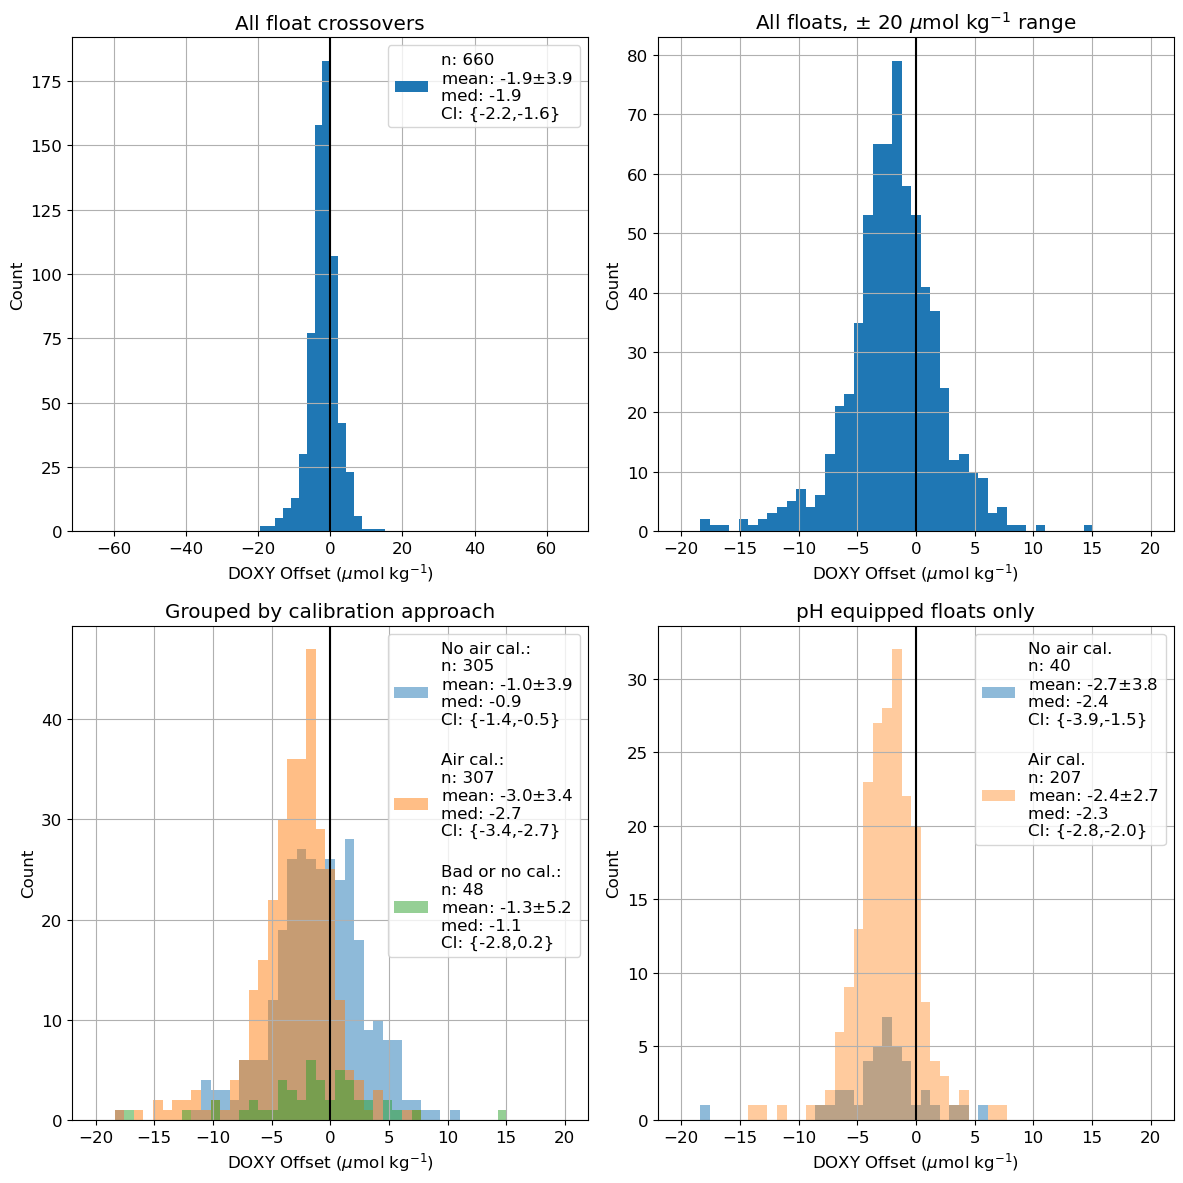

In [9]:
# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg
# x_val = 1 # offset in % 

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        pressure_level_min = pressure_levels[j]
        nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # nc_filename_all = filename[0:-3]+ '_all_offsets_depth_grouped_' + \
        #                         'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # if ~os.path.exists(grouped_plot_dir + nc_filename_mean):
        #     continue
        # load files and fix longitude
        # histogram plot for each file / pressure level
        if 'glodap_offsets_mean' in locals():
                del glodap_offsets_mean
        try:
                glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
        except:
                continue
        
                # don't need to fix longitude in this section of code
        # float_wmo_list = glodap_offsets_p.index.values
        # float_wmo_list = glodap_offsets_mean.main_float_wmo.values
        # if 'glodap_offsets' in locals():
        #     del glodap_offsets


        # glodap_offsets = xr.load_dataset(grouped_plot_dir + nc_filename_all)

        # # loop through mean array
        # for n in range(0,float_wmo_list.shape[0]):
        #         wmo_n = float_wmo_list[n]

        #         # fix long_n mean biases:
        #         temp_LONGITUDE = glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True)

        #         if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        #                 # print(n)
        #                 new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        #                 if new_mean>180:
        #                         new_mean = new_mean-360
                                
        #                 old_mean = np.mean(glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True))
        #                 # print('old mean: '  + str(old_mean.values))
        #                 # print('orig mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        #                 # print('new mean: '  + str(new_mean.values))

        #                 # put new LONGITUDE into long_n
        #                 glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}] = new_mean.values
        #                 # print('New mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        glodap_offsets_p = glodap_offsets_mean.to_dataframe()


        parameter_a = 'o2_calib_air_group'
        parameter_b = 'pH_group'
        offsets_g = glodap_offsets_p.groupby(parameter_a)
        offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])
        CI_level = 0.95
        plt.rcParams.update({'font.size': 12})

        plt.figure(figsize=(12,12))

        #All Float Crossovers
        plt.subplot(2,2,1)
        if x_val==0:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
                x_label = r'DOXY Offset ($\mu$mol kg$^{-1}$)'
        elif x_val==1:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
                x_label = 'DOXY Offset (%)'

        ncount = temp_var.count()
        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table = [('All', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax)]
        plt.hist(temp_var, 
                bins=np.linspace(-65, 65, 61), label='n: '+str(ncount.values) +  '\nmean: ' + str(nmean.values) + '$\pm$' + str(nstd.values) + '\nmed: ' + str(nmedian.values) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}'
                ) # ,label=str(n)
        #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
        plt.grid()
        plt.title('All float crossovers')
        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')
        plt.legend()

        # All float crossovers, zoomed in
        plt.subplot(2,2,2)
        plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')

        plt.hist(temp_var, 
                bins=np.linspace(-20, 20, 50),label='median='+str(nmedian.values) + 
                ', n='+str(ncount.values)) # ,label=str(n)
        plt.grid()
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.xlabel(x_label)

        # Split into calibration group
        plt.subplot(2,2,3)
        No_air_cal_all = offsets_g.get_group('no air cal')
        if x_val==0:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']/No_air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')



        air_cal_all = offsets_g.get_group('air cal')
        if x_val==0:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']/air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table.append(('Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')


        no_cal_all = offsets_g.get_group('no cal/bad')
        if x_val==0:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']/no_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Bad or no cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')



        #for n, group in offsets_g:
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

            

        plt.title('Grouped by calibration approach')

        plt.axvline(x=0, color='k')
        plt.grid()
        plt.xlabel(x_label)
        plt.ylabel('Count')

        plt.legend()

        # pH equipped floats only 
        plt.subplot(2,2,4)
        plt.title('pH equipped floats only')

        no_air_cal_ph = offsets_pH.get_group(('no air cal', 'pH'))
        if x_val==0:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/no_air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        ncount = temp_var.count()

        # temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')

        air_cal_ph = offsets_pH.get_group(('air cal', 'pH'))
        if x_val==0:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count()
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.4,label='Air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')


        #for n, group in offsets_pH:
        #    if n[1] == 'no pH' or n[0] == 'no cal/bad':
        #        continue
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.legend()
            
        plt.tight_layout()
        plt.grid()

        if x_val==0:
                plot_filename = nc_filename_mean
        elif x_val==1:
                plot_filename = nc_filename_mean + '_offset_percent'

        plt.savefig(grouped_plot_dir + plot_filename + '_histogram.png', dpi=300)

        print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
        

+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
|                       |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |   min |   max |
+=======================+=========+========+=======+=============+================+=================+==========+=======+=======+
| NITRATE_ADJUSTED      |     330 |    0.2 |   0.4 | 6.71923e-15 |           0.14 |            0.22 |      0.2 |  -2.3 |   1.8 |
+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| pH_25C_TOTAL_ADJUSTED |     137 |   -5.6 |   7.5 | 8.79363e-15 |          -6.85 |           -4.34 |     -4.5 | -40   |  14.1 |
+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| DIC                   |     188 |    3.6 |   7   | 6.4636e-11  |           2.56 |            4.

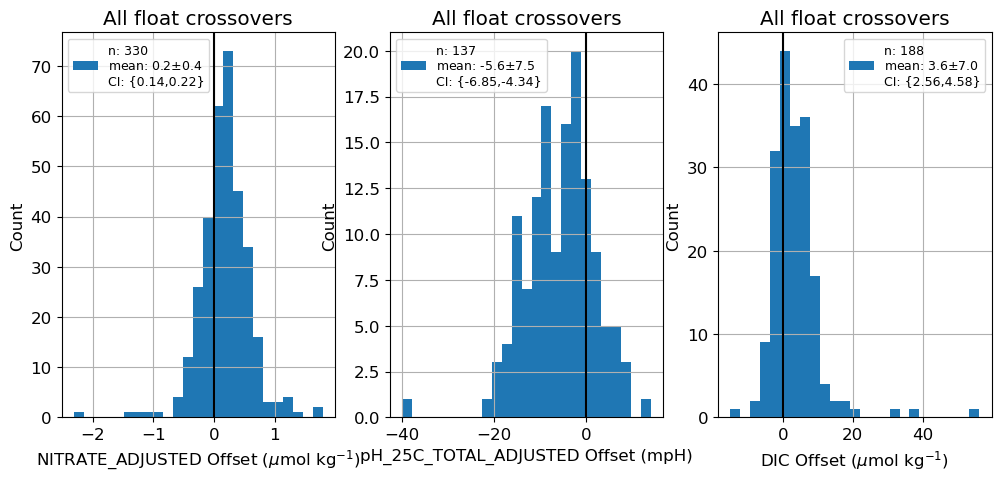

In [10]:
## plot nitrate, pH, DIC offsets for each file / grouping 
CI_level = 0.95
var_plot = ['NITRATE_ADJUSTED','pH_25C_TOTAL_ADJUSTED', 'DIC']

# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

                pressure_level_min = pressure_levels[j]
                nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

                if 'glodap_offsets_mean' in locals():
                    del glodap_offsets_mean
                try:
                        glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
                except:
                        continue
                
                # plt.rcParams.update({'font.size': 12})
                o2_offset_data_table = []
               
                plt.figure(figsize=(12,5))

                for v, var in enumerate(var_plot):
                    if np.logical_or(var=='PH_IN_SITU_TOTAL_ADJUSTED', var=='pH_25C_TOTAL_ADJUSTED'):
                        scale = 1000
                        x_label_units = '(mpH)'
                    else:
                        scale = 1
                        x_label_units = '($\mu$mol kg$^{-1}$)'
                    #All Float Crossovers
                    plt.subplot(1,3,v+1)
                    ncount = glodap_offsets_mean[var_plot[v] + '_offset'].count().values
                    nmean = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].mean().values*scale, decimals=1)
                    nstd = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].std().values*scale, decimals=1)
                    nmedian = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].median().values*scale, decimals=1)
                    nmin = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].min().values*scale, decimals=1)
                    nmax = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].max().values*scale, decimals=1)

                    temp_var = glodap_offsets_mean[var_plot[v] + '_offset']*scale
                    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                    CI_vals = stats.norm.interval(confidence=CI_level, 
                                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                    CI_low = np.around(CI_vals[0], decimals=2)
                    CI_high = np.around(CI_vals[1], decimals=2)
                    o2_offset_data_table.append([var_plot[v], 
                                                ncount, 
                                                nmean, 
                                                nstd, 
                                                p_value, CI_low, CI_high, nmedian, nmin, nmax])
                    plt.hist(glodap_offsets_mean[var_plot[v] + '_offset']*scale, 
                            label='n: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
                        '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}',bins=25) # ,label=str(n) #bins=np.linspace(-65, 65, 61),
                    #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
                    plt.grid()
                    plt.title('All float crossovers')
                    plt.xlabel(var_plot[v] + ' Offset ' + x_label_units)
                    plt.ylabel('Count')
                    plt.axvline(x=0, color='k')
                    plt.legend(fontsize=9)
                plt.tight_layout

                plot_filename = nc_filename_mean

                plt.savefig(grouped_plot_dir + plot_filename + '_no3_pH_dic_histogram.png', dpi=300)

                print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))


In [ ]:
mean_gdap_offsets

### Setting group names for projects, sensor types, data centers, etc.

In [11]:
# Assuming 'project_name' is the variable in your xarray dataset
dataset_n = mean_gdap_offsets[filename]['level_1500']
project_name_values = dataset_n['project_name'].values
big_projects = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(project_name_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=10:
        big_projects.append(group_name)

print(big_projects)

Group Name:                                                                 , Count: 14
Group Name: AMOP                                                            , Count: 2
Group Name: ARGO GEOMAR                                                     , Count: 2
Group Name: ARGO Italy                                                      , Count: 1
Group Name: ARGO Norway                                                     , Count: 4
Group Name: ARGO-BSH                                                        , Count: 2
Group Name: ARGO_SPAIN                                                      , Count: 1
Group Name: Argo Australia, Count: 1
Group Name: Argo Australia                                                  , Count: 56
Group Name: Argo Canada                                                     , Count: 14
Group Name: Argo GERMANY                                                    , Count: 1
Group Name: Argo INDIA                                                      , Count: 15
Gr

In [12]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
data_center_values = dataset_n['data_centre'].values
data_centers = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(data_center_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=5:
        data_centers.append(group_name)

print(data_centers)

Group Name: AO, Count: 582
Group Name: BO, Count: 4
Group Name: CS, Count: 57
Group Name: IF, Count: 183
Group Name: IN, Count: 17
Group Name: JA, Count: 13
Group Name: ME, Count: 14
['AO', 'CS', 'IF', 'IN', 'JA', 'ME']


In [13]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
o2_sensor_values = dataset_n['DOXY_sensor'].values
o2_sensors = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(o2_sensor_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=1:
        o2_sensors.append(group_name)

print(o2_sensors)

Group Name: 3830                                                                                                                                                                                                                                                            , Count: 1
Group Name: AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            , Count: 139
Group Name: AANDERAA_OPTODE_4330                                                                                                                                                                                                                                            , Count: 550
Group Name: ARO_FT                                                                                                                                             

In [ ]:
np.mean([float_age_bins[fa], float_age_bins[fa+1]])

In [29]:
dataset_n

<xarray.Dataset>
Dimensions:                               (main_float_wmo: 883)
Coordinates:
  * main_float_wmo                        (main_float_wmo) object '1900722' ....
Data variables: (12/72)
    p_compare_min                         (main_float_wmo) float64 400.0 ... ...
    p_compare_max                         (main_float_wmo) float64 2.1e+03 .....
    delta_dens                            (main_float_wmo) float64 0.005 ... ...
    delta_spice                           (main_float_wmo) float64 0.005 ... ...
    delta_press                           (main_float_wmo) float64 100.0 ... ...
    dist                                  (main_float_wmo) float64 100.0 ... ...
    ...                                    ...
    pH_sensor                             (main_float_wmo) object 'none' ... ...
    nitrate_group                         (main_float_wmo) object 'no nitrate...
    nitrate_sensor                        (main_float_wmo) object 'none' ... ...
    DOXY_group                            (main_float_wmo) object 'DOXY' ... ...
    DOXY_sensor                           (main_float_wmo) object 'AANDERAA_O...
    ice_group                             (main_float_wmo) object 'no ice' .....

In [31]:
dataset_n.where(abs(dataset_n['main_float_latitude'])<60)
dataset_n

<xarray.Dataset>
Dimensions:                               (main_float_wmo: 883)
Coordinates:
  * main_float_wmo                        (main_float_wmo) object '1900722' ....
Data variables: (12/72)
    p_compare_min                         (main_float_wmo) float64 400.0 ... ...
    p_compare_max                         (main_float_wmo) float64 2.1e+03 .....
    delta_dens                            (main_float_wmo) float64 0.005 ... ...
    delta_spice                           (main_float_wmo) float64 0.005 ... ...
    delta_press                           (main_float_wmo) float64 100.0 ... ...
    dist                                  (main_float_wmo) float64 100.0 ... ...
    ...                                    ...
    pH_sensor                             (main_float_wmo) object 'none' ... ...
    nitrate_group                         (main_float_wmo) object 'no nitrate...
    nitrate_sensor                        (main_float_wmo) object 'none' ... ...
    DOXY_group                            (main_float_wmo) object 'DOXY' ... ...
    DOXY_sensor                           (main_float_wmo) object 'AANDERAA_O...
    ice_group                             (main_float_wmo) object 'no ice' .....

In [38]:
temp_dataset.keys()

Index(['p_compare_min', 'p_compare_max', 'delta_dens', 'delta_spice',
       'delta_press', 'dist', 'PRES_ADJUSTED_offset', 'PRES_ADJUSTED_glodap',
       'PRES_ADJUSTED_float', 'TEMP_ADJUSTED_offset', 'TEMP_ADJUSTED_glodap',
       'TEMP_ADJUSTED_float', 'PSAL_ADJUSTED_offset', 'PSAL_ADJUSTED_glodap',
       'PSAL_ADJUSTED_float', 'DOXY_ADJUSTED_offset', 'DOXY_ADJUSTED_glodap',
       'DOXY_ADJUSTED_float', 'NITRATE_ADJUSTED_offset',
       'NITRATE_ADJUSTED_glodap', 'NITRATE_ADJUSTED_float', 'DIC_offset',
       'DIC_glodap', 'DIC_float', 'pH_25C_TOTAL_ADJUSTED_offset',
       'pH_25C_TOTAL_ADJUSTED_glodap', 'pH_25C_TOTAL_ADJUSTED_float',
       'PH_IN_SITU_TOTAL_ADJUSTED_offset', 'PH_IN_SITU_TOTAL_ADJUSTED_glodap',
       'PH_IN_SITU_TOTAL_ADJUSTED_float', 'PDENS_offset', 'PDENS_glodap',
       'PDENS_float', 'pH_25C_T_P1500_offset', 'pH_25C_T_P1500_glodap',
       'pH_25C_T_P1500_float', 'main_float_profile', 'main_float_longitude',
       'glodap_longitude', 'main_float_latitude',

In [43]:

data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()


main_float_wmo
1900722         NaN
1900943         NaN
1901134    0.095811
1901135    1.942910
1901152         NaN
             ...   
6902881         NaN
6903180         NaN
6903197         NaN
6903204         NaN
6903222         NaN
Length: 429, dtype: float64

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/1858151242.py:97: RuntimeWarning: Mean of empty slice
  loc=np.nanmean(temp_var[~np.i

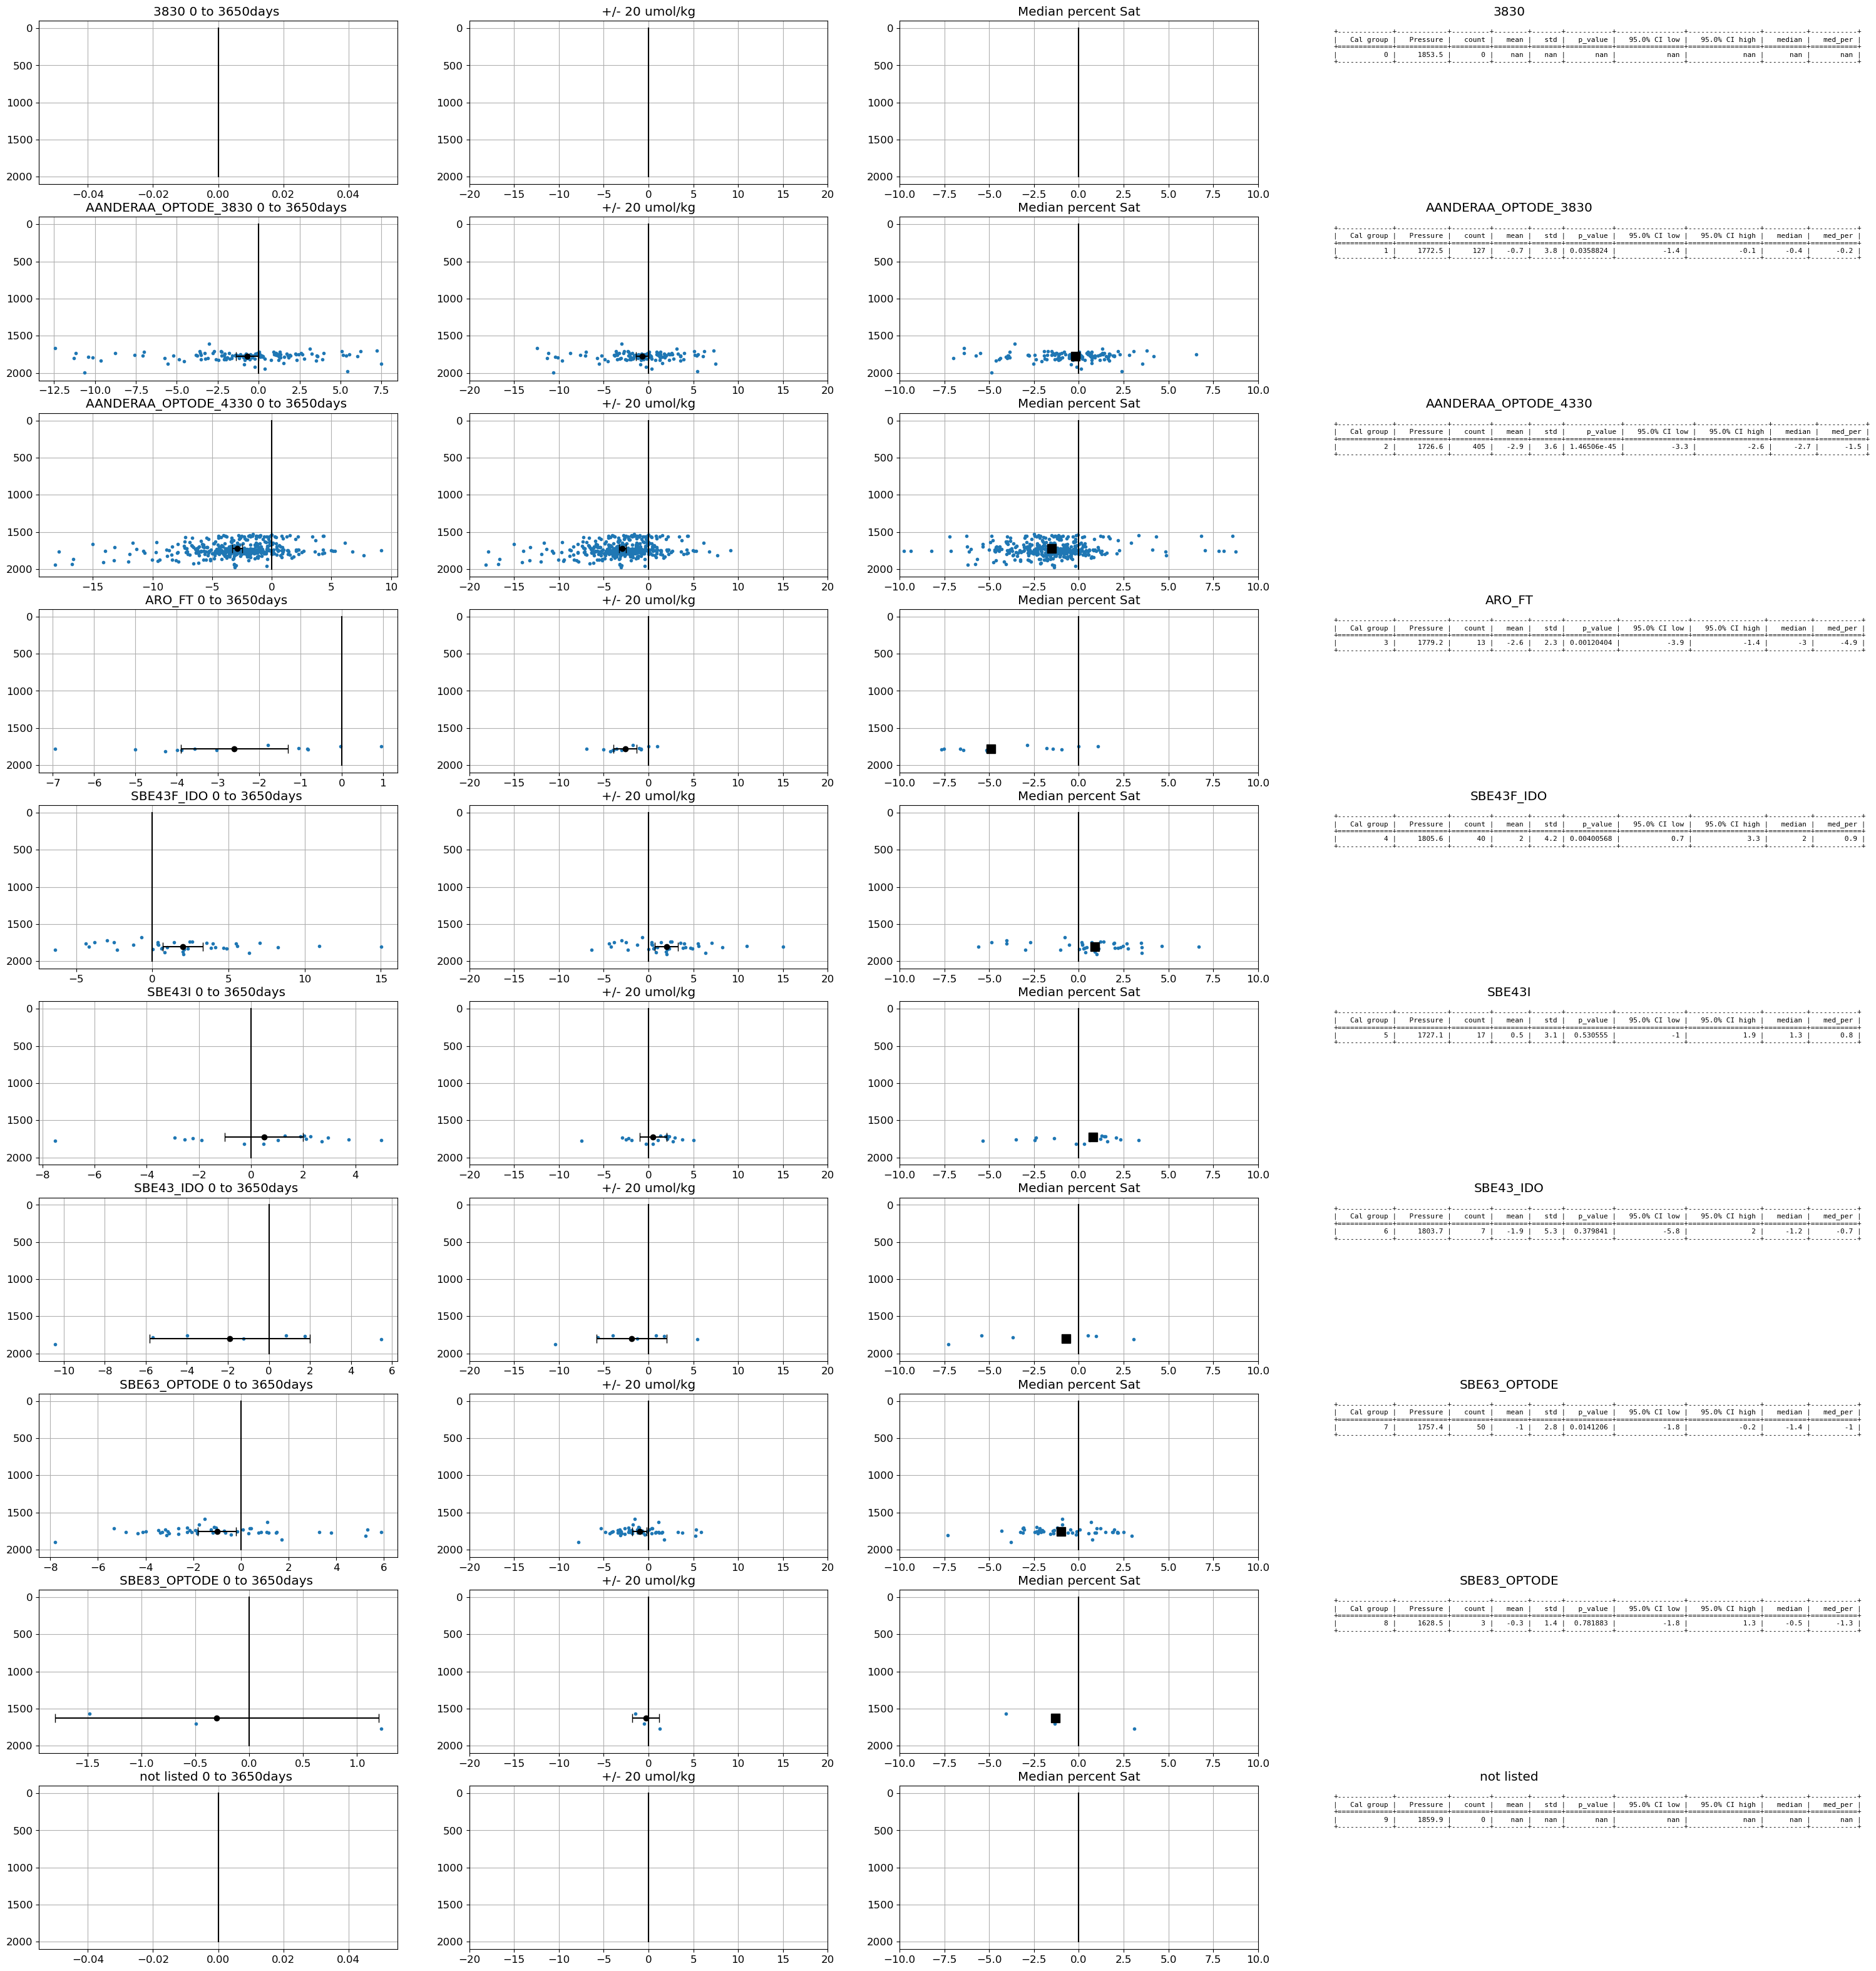

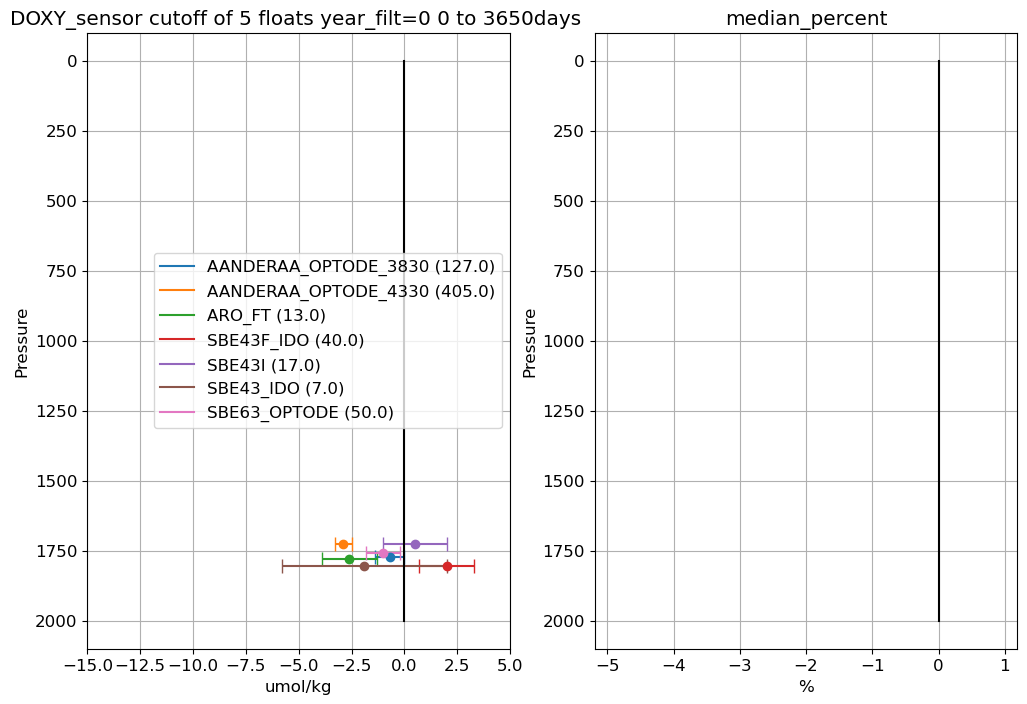

In [14]:
# # want to loop through and save out all pressure values for each type (cal_group) so that I can make some synthesis plots

# cal_groups_all  = [['All', 'air cal', 'no air cal'], o2_sensors, big_projects, data_centers]
# parameter_a_all= ['o2_calib_air_group', 'DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'

# cal_groups = ['All', 'air cal', 'no air cal']
# parameter_a = 'o2_calib_air_group'

# cal_groups = big_projects
# parameter_a = 'project_name'

cal_groups  = o2_sensors
parameter_a= 'DOXY_sensor' 

# cal_groups = data_centers
# parameter_a = 'data_centre'

CI_level = 0.95

float_age_filter = 1
# for n, cal_groups in enumerate(cal_groups_all):
#     parameter_a = parameter_a_all[n]

abs_lat_cutoff_shallow = 55

for fa in range(len(float_age_bins)-1):
    o2_offset_data_table = []

    fig = plt.figure(figsize=(34,len(cal_groups)*4))

    for filename in glodap_offsets_filenames:
        
        for j in range(len(pressure_levels)-1):
            try:
                dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
            except:
                continue   

            # if pressure levels are too shallow, remove data in high latitudes given issues with stratification
            if pressure_levels[j]<500:
                dataset_n = dataset_n.where(abs(dataset_n['main_float_latitude'])<abs_lat_cutoff_shallow)

              
            for idx, cal in enumerate(cal_groups):
                dataset_p = dataset_n.to_dataframe()
                offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

                if float_age_filter==0:
                    var = 'DOXY_ADJUSTED_offset_trimmed'
                else:
                    var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
                    age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '

                if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                    # print(idx)
                    # print(cal)
                    data_p = dataset_n[var].copy()
                    pressure_p = dataset_n.PRES_ADJUSTED_float
                    data_mag_p = dataset_n['DOXY_ADJUSTED_float'].copy()
                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = dataset_n[var + '_count']
                        data_p[count_p < 20] = np.nan

                else:
                    temp_dataset = offsets_o2_cal_group.get_group(cal)
                    data_p = temp_dataset[var].copy()
                    pressure_p = temp_dataset.PRES_ADJUSTED_float
                    data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()

                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = temp_dataset[var + '_count']
                        data_p[count_p < 20] = np.nan

            

                nmean = np.around(data_p.mean(), decimals=1)
                ncount = np.around(data_p.count(), decimals=1)
                nstd = np.around(data_p.std(), decimals=1)
                nmedian = np.around(data_p.median(), decimals=1)

                percent_sat_mag = data_p/data_mag_p*100
                nmedian_percent_mag = np.around(percent_sat_mag.median(), decimals=1)

                temp_var = data_p.copy()
                t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                CI_vals = stats.norm.interval(confidence=CI_level, 
                                loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                CI_low = np.around(CI_vals[0], decimals=1)
                CI_high = np.around(CI_vals[1], decimals=1)
                ax1 = plt.subplot(len(cal_groups),4,(1+4*idx))
                if float_age_filter==0:
                    plt.title(cal.strip() )
                else:
                    plt.title(cal.strip() + ' ' + age_title)
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                plt.grid('on')
                ax2 = plt.subplot(len(cal_groups),4,(2+4*idx))
                plt.title('+/- 20 umol/kg')
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                npres = np.around(pressure_p.mean(), decimals=1)
                plt.xlim([-20, 20])
                plt.grid('on')
                o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmedian_percent_mag))

                # plot offset in percent saturation
                ax2 = plt.subplot(len(cal_groups),4,(3+4*idx))
                plt.title('Median percent Sat')
                plt.plot(percent_sat_mag, pressure_p,'.')
                plt.plot(nmedian_percent_mag, pressure_p.mean(),'sk', markersize=10, linewidth=10)

                # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                plt.xlim([-10, 10])
                plt.grid('on')

    for idx, cal in enumerate(cal_groups):
        plt.subplot(len(cal_groups),4,(1+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')
        plt.subplot(len(cal_groups),4,(2+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')

        plt.subplot(len(cal_groups),4,(3+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')

    o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
    sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

    # base_value = 1
    # increment = 3
    # num_iterations = 10  

    # for idx in range(num_iterations):
    #     current_value = base_value + increment * idx
    #     print(f"Index: {idx}, Value: {current_value}")

    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
        # Create a string buffer to store the table
        table_buffer = StringIO()

        # Convert the o2_offset_data_table to a table and write it to the buffer
        print(tabulate(filtered_data_table, 
                    headers=['Cal group', 'Pressure', 'count',
                                'mean', 'std', 'p_value', 
                                str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
                                'median', 'med_per'], tablefmt='grid'), file=table_buffer)

        # Display the table in a subplot
        plt.subplot(len(cal_groups),4,(4+4*idx))
        plt.title(cal.strip())

        plt.axis('off')  # Turn off axis for the table
        # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
        plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
        
        # break

    plot_filename = var + '_vs_depth_grouped_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    plt.savefig(grouped_plot_dir + plot_filename + '.png', dpi=300)

    o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    
    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

        for i in range(0,len(filtered_data_table)):
            new_data_o2_direct_impact = [(cal.strip(), 
                                        filtered_data_table[i][1], 
                                        filtered_data_table[i][3],
                                        filtered_data_table[i][6],
                                        filtered_data_table[i][7],
                                        filtered_data_table[i][2],
                                        filtered_data_table[i][9])]
            new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
            o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

    if parameter_a=='project_name':
        n_cutoff= 10
        x_lim = [-25, 10]
    elif parameter_a=='DOXY_sensor':
        n_cutoff = 5
        x_lim = [-15, 5]
    elif parameter_a == 'o2_calib_air_group':
        n_cutoff = 0
        x_lim = [-10, 2.5]
    elif parameter_a == 'data_centre':
        n_cutoff = 5
        x_lim = [-22, 5]


    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    for cal in cal_groups:
        temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

        if temp_group.n_count.values.mean()<n_cutoff:
            continue

        line, = ax1.plot(temp_group.offset, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')
        line, = ax2.plot(temp_group.per_med, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')

        line_color = line.get_color()
        for i in range(0,len(temp_group)):
            ax1.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                        fmt='o', capsize=5, color=line_color)

    ax1.invert_yaxis()
    ax2.invert_yaxis()

    ax1.plot([0,0], [0, 2000], 'k-')
    ax2.plot([0,0], [0, 2000], 'k-')

    ax1.grid('on')
    ax2.grid('on')

    ax1.set_xlim(x_lim)
    ax1.legend()
    if float_age_filter==0:
        ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))

    else:
        ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt) + ' ' + age_title)
    ax2.set_title('median_percent')

    ax1.set_xlabel('umol/kg')
    ax2.set_xlabel('%')

    ax1.set_ylabel('Pressure')
    ax2.set_ylabel('Pressure')

    plot_filename = var + 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    
    if float_age_filter==0:
        break

    


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: Run

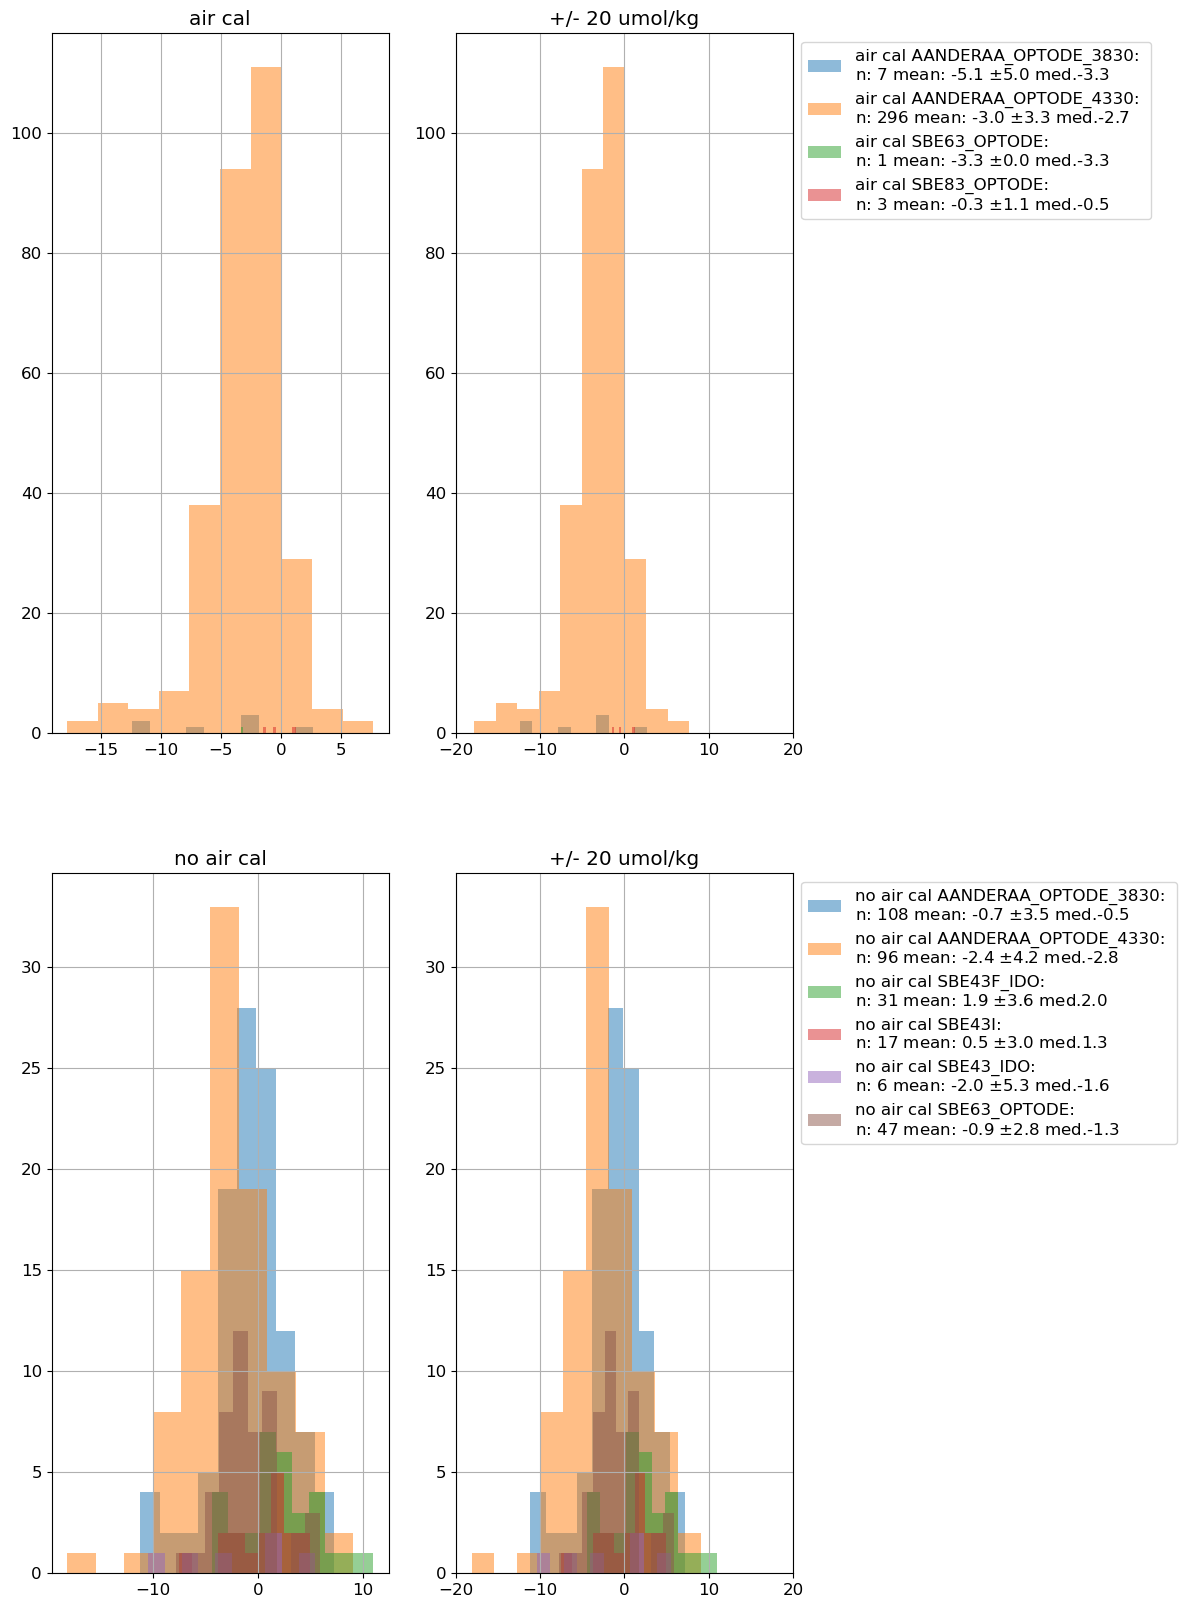

In [15]:
# # multiple groupings of parameters

# cal_groups_all  = [['All', 'air cal', 'no air cal'], o2_sensors, big_projects, data_centers]
# parameter_a_all= ['o2_calib_air_group', 'DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'



# cal_groups = big_projects
# parameter_a = 'project_name'

cal_groups_b  = o2_sensors
parameter_b= 'DOXY_sensor' 

cal_groups_a = ['air cal', 'no air cal']
parameter_a = 'o2_calib_air_group'


# cal_groups = data_centers
# parameter_a = 'data_centre'

CI_level = 0.95

float_age_filter = 0
# for n, cal_groups in enumerate(cal_groups_all):
#     parameter_a = parameter_a_all[n]

abs_lat_cutoff_shallow = 55


# AA = dataset_n.where(dataset_n['o2_calib_air_group']=='air cal', drop=True)
# BB = AA.where(AA['DOXY_sensor']==o2_sensors[1], drop=True)

for fa in range(len(float_age_bins)-1):
    o2_offset_data_table = []

    fig = plt.figure(figsize=(20,len(cal_groups_a)*10))

    for filename in glodap_offsets_filenames:
        
        for j in range(len(pressure_levels)-1):
            try:
                dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
            except:
                continue   

            # if pressure levels are too shallow, remove data in high latitudes given issues with stratification
            if pressure_levels[j]<500:
                dataset_n = dataset_n.where(abs(dataset_n['main_float_latitude'])<abs_lat_cutoff_shallow)

              
            for idx, cal_a in enumerate(cal_groups_a):
                dataset_1_filter = dataset_n.where(dataset_n[parameter_a]==cal_a, drop=True)

                for idx2, cal_b in enumerate(cal_groups_b):
                    dataset_2_filter = dataset_n.where(dataset_1_filter[parameter_b]==cal_b, drop=True)

                    if float_age_filter==0:
                        var = 'DOXY_ADJUSTED_offset_trimmed'
                    else:
                        var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
                        age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '



                    nmean = np.around(dataset_2_filter[var].mean().values, decimals=1)
                    ncount = np.around(dataset_2_filter[var].count().values, decimals=1)
                    nstd = np.around(dataset_2_filter[var].std().values, decimals=1)
                    nmedian = np.around(dataset_2_filter[var].median().values, decimals=1)

                    percent_sat_mag = data_p/data_mag_p*100
                    nmedian_percent_mag = np.around(percent_sat_mag.median(), decimals=1)

                    # temp_var = dataset_2_filter.copy()
                    # t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                    # CI_vals = stats.norm.interval(confidence=CI_level, 
                    #                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    #                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                    # CI_low = np.around(CI_vals[0], decimals=1)
                    # CI_high = np.around(CI_vals[1], decimals=1)
                    ax1 = plt.subplot(len(cal_groups_a),4,(1+4*idx))
                    if float_age_filter==0:
                        plt.title(cal_a.strip())
                    else:
                        plt.title(cal.strip() + ' ' + age_title)
                    # plt.plot(data_p, pressure_p,'.')
                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                    if np.sum(~np.isnan(dataset_2_filter[var].values))==0:
                        continue
                    plt.hist(dataset_2_filter[var], alpha=0.5, 
                             label=cal_a.strip() + ' ' + cal_b.strip() + ': \nn: '+str(ncount) +  ' mean: ' + str(nmean) + ' $\pm$' + str(nstd) + ' med.' + str(nmedian))

                    plt.grid('on')
                    ax2 = plt.subplot(len(cal_groups_a),4,(2+4*idx))
                    plt.title('+/- 20 umol/kg')
                    # plt.plot(data_p, pressure_p,'.')
                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')
                    plt.hist(dataset_2_filter[var], alpha=0.5,
                             label=cal_a.strip() + ' ' + cal_b.strip() + ': \nn: '+str(ncount) +  ' mean: ' + str(nmean) + ' $\pm$' + str(nstd)+ ' med.' + str(nmedian))

                    # npres = np.around(pressure_p.mean(), decimals=1)
                    plt.xlim([-20, 20])
                    plt.grid('on')
                    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

                    # o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmedian_percent_mag))

                    # plot offset in percent saturation
                    # ax2 = plt.subplot(len(cal_groups),4,(3+4*idx))
                    # plt.title('Median percent Sat')
                    # plt.plot(percent_sat_mag, pressure_p,'.')
                    # plt.plot(nmedian_percent_mag, pressure_p.mean(),'sk', markersize=10, linewidth=10)

                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                    # plt.xlim([-10, 10])
                    # plt.grid('on')
                
            break
        break
    plot_filename = var + 'Offsets_grouped_by_' + parameter_a + ' ' + parameter_b
    fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    break

    #             dataset_p = dataset_n.to_dataframe()
    #             offsets_o2_cal_group = dataset_p.groupby(parameter_a)
    #             # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

    #             if float_age_filter==0:
    #                 var = 'DOXY_ADJUSTED_offset_trimmed'
    #             else:
    #                 var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
    #                 age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '

    #             if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
    #                 # print(idx)
    #                 # print(cal)
    #                 data_p = dataset_n[var].copy()
    #                 pressure_p = dataset_n.PRES_ADJUSTED_float
    #                 data_mag_p = dataset_n['DOXY_ADJUSTED_float'].copy()
    #                 if float_age_filter==1:
    #                     # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
    #                     count_p = dataset_n[var + '_count']
    #                     data_p[count_p < 20] = np.nan

    #             else:
    #                 temp_dataset = offsets_o2_cal_group.get_group(cal)
    #                 data_p = temp_dataset[var].copy()
    #                 pressure_p = temp_dataset.PRES_ADJUSTED_float
    #                 data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()

    #                 if float_age_filter==1:
    #                     # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
    #                     count_p = temp_dataset[var + '_count']
    #                     data_p[count_p < 20] = np.nan

            

    #             

    # for idx, cal in enumerate(cal_groups):
    #     plt.subplot(len(cal_groups),4,(1+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')
    #     plt.subplot(len(cal_groups),4,(2+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')

    #     plt.subplot(len(cal_groups),4,(3+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')

    # o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
    # sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

    # # base_value = 1
    # # increment = 3
    # # num_iterations = 10  

    # # for idx in range(num_iterations):
    # #     current_value = base_value + increment * idx
    # #     print(f"Index: {idx}, Value: {current_value}")

    # for idx, cal in enumerate(cal_groups):
    #     filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    #     # Create a string buffer to store the table
    #     table_buffer = StringIO()

    #     # Convert the o2_offset_data_table to a table and write it to the buffer
    #     print(tabulate(filtered_data_table, 
    #                 headers=['Cal group', 'Pressure', 'count',
    #                             'mean', 'std', 'p_value', 
    #                             str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
    #                             'median', 'med_per'], tablefmt='grid'), file=table_buffer)

    #     # Display the table in a subplot
    #     plt.subplot(len(cal_groups),4,(4+4*idx))
    #     plt.title(cal.strip())

    #     plt.axis('off')  # Turn off axis for the table
    #     # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    #     plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
        
    #     # break

    # plot_filename = var + '_vs_depth_grouped_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    # plt.savefig(grouped_plot_dir + plot_filename + '.png', dpi=300)

    # o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    
    # for idx, cal in enumerate(cal_groups):
    #     filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

    #     for i in range(0,len(filtered_data_table)):
    #         new_data_o2_direct_impact = [(cal.strip(), 
    #                                     filtered_data_table[i][1], 
    #                                     filtered_data_table[i][3],
    #                                     filtered_data_table[i][6],
    #                                     filtered_data_table[i][7],
    #                                     filtered_data_table[i][2],
    #                                     filtered_data_table[i][9])]
    #         new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    #         o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

    # if parameter_a=='project_name':
    #     n_cutoff= 10
    #     x_lim = [-25, 10]
    # elif parameter_a=='DOXY_sensor':
    #     n_cutoff = 5
    #     x_lim = [-15, 5]
    # elif parameter_a == 'o2_calib_air_group':
    #     n_cutoff = 0
    #     x_lim = [-10, 2.5]
    # elif parameter_a == 'data_centre':
    #     n_cutoff = 5
    #     x_lim = [-22, 5]


    # fig = plt.figure(figsize=(12,8))
    # ax1 = plt.subplot(1,2,1)
    # ax2 = plt.subplot(1,2,2)

    # for cal in cal_groups:
    #     temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

    #     if temp_group.n_count.values.mean()<n_cutoff:
    #         continue

    #     line, = ax1.plot(temp_group.offset, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')
    #     line, = ax2.plot(temp_group.per_med, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')

    #     line_color = line.get_color()
    #     for i in range(0,len(temp_group)):
    #         ax1.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
    #                     fmt='o', capsize=5, color=line_color)

    # ax1.invert_yaxis()
    # ax2.invert_yaxis()

    # ax1.plot([0,0], [0, 2000], 'k-')
    # ax2.plot([0,0], [0, 2000], 'k-')

    # ax1.grid('on')
    # ax2.grid('on')

    # ax1.set_xlim(x_lim)
    # ax1.legend()
    # if float_age_filter==0:
    #     ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))

    # else:
    #     ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt) + ' ' + age_title)
    # ax2.set_title('median_percent')

    # ax1.set_xlabel('umol/kg')
    # ax2.set_xlabel('%')

    # ax1.set_ylabel('Pressure')
    # ax2.set_ylabel('Pressure')

    # plot_filename = var + 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    # fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    
    # if float_age_filter==0:
    #     break

    


In [67]:
sorted_data_table

[(0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(59.9),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(230),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-5.2),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(11.3),
  2.8099771664959656e-11,
  -6.7,
  -3.8,
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-4.2),
  <xarray.DataArray ()>
  array(-1.7)),
 (0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(149.4),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(241),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-6.4),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(10.4),
  4.042091156341461e-18,
  -7.7,
  -5.0,
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-4.7),
  <xarray.DataArray ()>
  array(-2.9)),
 (0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(250.2),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(215),
  <xarray.DataArray 'DOXY_AD

3830                                                                                                                                                                                                                                                            
AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            
AANDERAA_OPTODE_4330                                                                                                                                                                                                                                            
ARO_FT                                                                                                                                                                                                                               

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


AO
CS
IF
IN
JA
ME


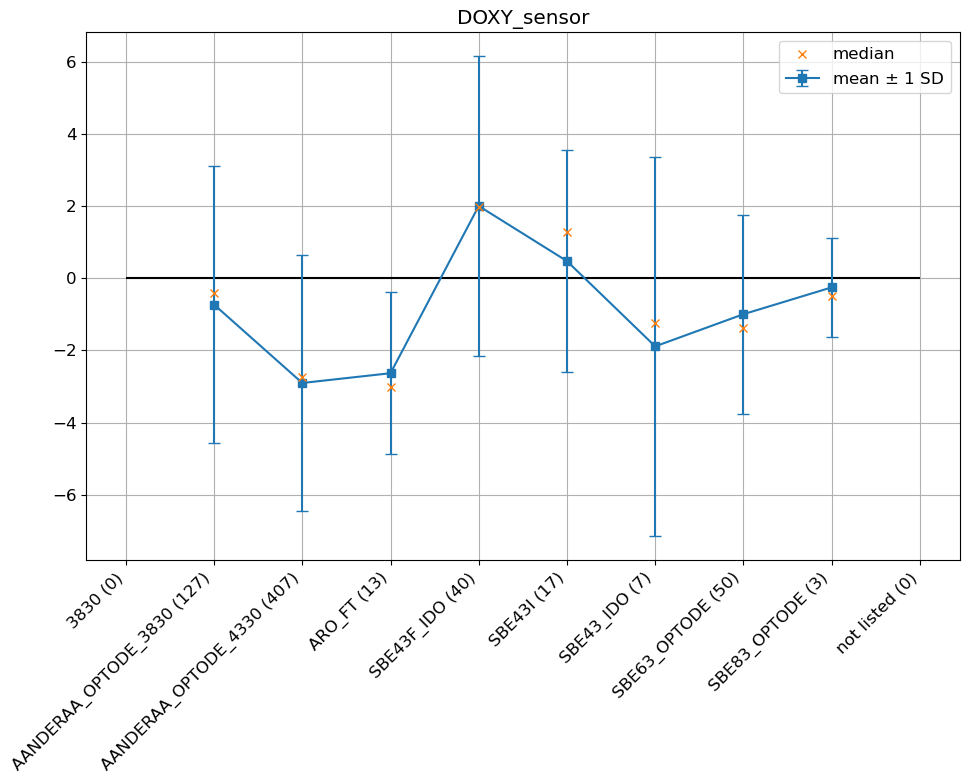

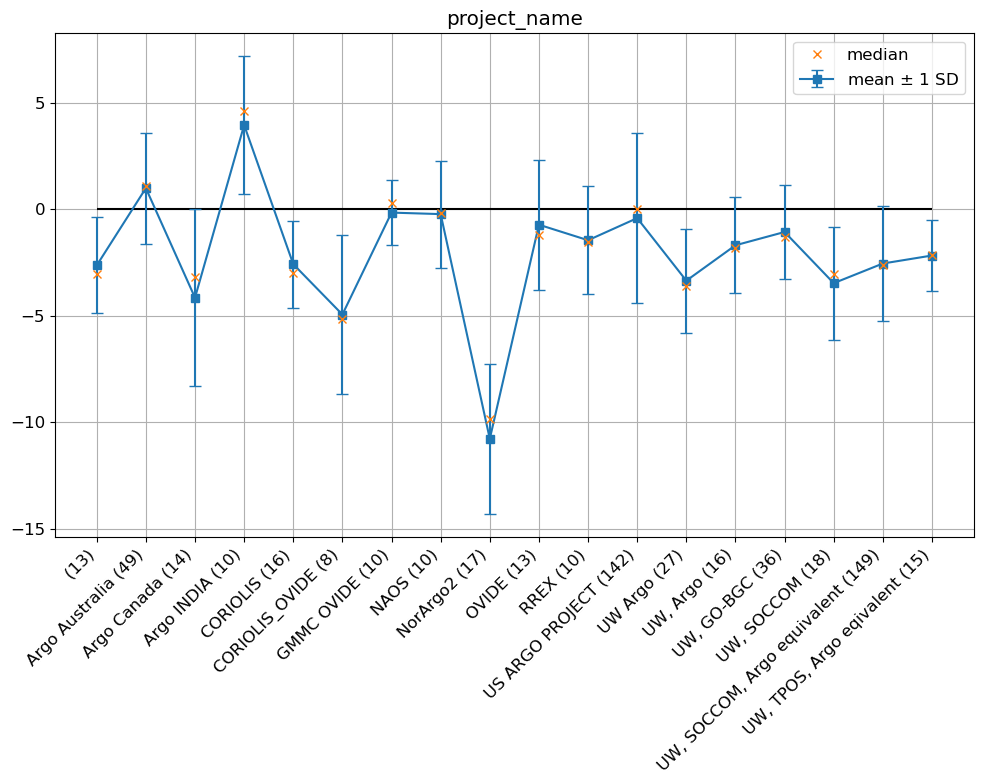

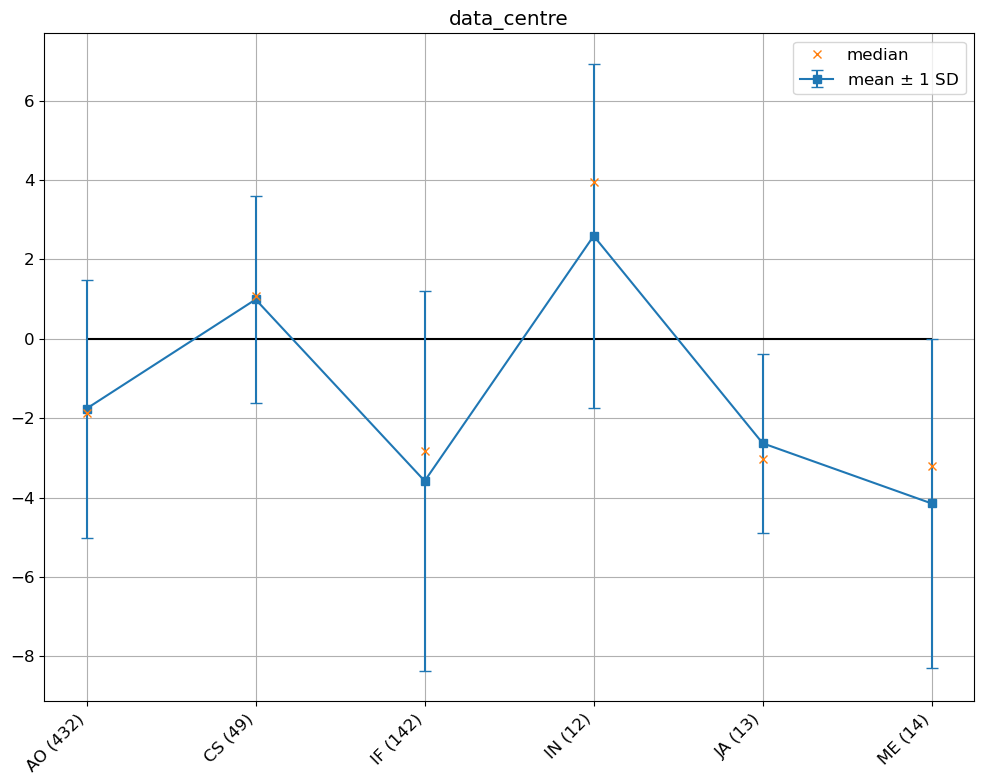

In [15]:
# plots of means, SDs, and medians for various groupings 
cal_groups_all  = [o2_sensors, big_projects, data_centers]
parameter_a_all= ['DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'
for n, cal_groups in enumerate(cal_groups_all):
    parameter_a = parameter_a_all[n]
    cal_group_labels = []
    for fa in range(len(float_age_bins)-1):
        o2_offset_data_table = []
        means = []
        stds = []
        medians = []
        counts = []

        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(1,1,1)
        for filename in glodap_offsets_filenames:
            
            for j in range(len(pressure_levels)-1):
                try:
                    dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
                except:
                    continue    
                for idx, cal in enumerate(cal_groups):
                    dataset_p = dataset_n.to_dataframe()
                    offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                    if float_age_filter==0:
                        var = 'DOXY_ADJUSTED_offset_trimmed'
                    else:
                        var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])

                    if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                        # print(idx)
                        # print(cal)
                        data_p = dataset_n[var].copy()
                        pressure_p = dataset_n.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = dataset_n[var + '_count']
                            data_p[count_p < 20] = np.nan
                    else:
                        temp_dataset = offsets_o2_cal_group.get_group(cal)
                        data_p = temp_dataset[var].copy()
                        pressure_p = temp_dataset.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = temp_dataset[var + '_count']
                            data_p[count_p < 20] = np.nan
                        print(cal)
                    # nmean = np.around(data_p.mean(), decimals=1)
                    # ncount = np.around(data_p.count(), decimals=1)
                    # nstd = np.around(data_p.std(), decimals=1)
                    # nmedian = np.around(data_p.median(), decimals=1)
                    cal_group_labels.append(cal.strip() + ' (' + str(data_p.count())+ ')')

                    means.append(data_p.mean())
                    stds.append(data_p.std())
                    counts.append(data_p.count())
                    medians.append(data_p.median())

        x = np.arange(len(cal_group_labels))

        plt.hlines(0, xmin=0, xmax=len(cal_group_labels)-1, colors='k')
        plt.grid('on')
        # plt.plot(x, means, 's', label='mean')
        plt.errorbar(x, means, yerr=stds, marker='s', label='mean $\pm$ 1 SD', capsize=4)
        plt.plot(x, medians, 'x', label='median', zorder=4, linewidth=4)

        ax.set_xticks(x, labels=cal_group_labels, rotation=45, ha='right')
        # ax.set_xticklabels(cal_group_labels, rotation=45, ha='right')
        ax.set_title(parameter_a)
        ax.legend()
        plt.tight_layout()
        plot_filename = var + '_means_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)

        plt.savefig(grouped_plot_dir + plot_filename + '.png')
    
            
        

In [ ]:

o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

    for i in range(0,len(filtered_data_table)):
        new_data_o2_direct_impact = [(cal.strip(), 
                                      filtered_data_table[i][1], 
                                      filtered_data_table[i][3],
                                      filtered_data_table[i][6],
                                      filtered_data_table[i][7],
                                      filtered_data_table[i][2])]
        new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
        o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

if parameter_a=='project_name':
    n_cutoff= 30
    x_lim = [-25, 10]
elif parameter_a=='DOXY_sensor':
    n_cutoff = 20
    x_lim = [-15, 5]
elif parameter_a == 'o2_calib_air_group':
    n_cutoff = 0
    x_lim = [-10, 2.5]
elif parameter_a == 'data_centre':
    n_cutoff = 30
    x_lim = [-22, 5]


fig = plt.figure(figsize=(8,8))

for cal in cal_groups:
    temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

    if temp_group.n_count.values.mean()<n_cutoff:
        continue

    line, = plt.plot(temp_group.offset, temp_group.pressure, label=cal.strip())
    
    line_color = line.get_color()
    for i in range(0,len(temp_group)):
        plt.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                      fmt='o', capsize=5, color=line_color)

plt.gca().invert_yaxis()
plt.plot([0,0], [0, 2000], 'k-')
plt.grid('on')
plt.xlim(x_lim)
plt.legend()
plt.title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))
plt.xlabel('umol/kg')
plt.ylabel('Pressure')
plot_filename = 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)
plt.savefig(grouped_plot_dir  + plot_filename + '.png')

In [ ]:
gdap_offsets[filename]['level_1500'].main_float_wmo=='5903615'

In [ ]:
filtered_data_table

In [ ]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

# base_value = 1
# increment = 3
# num_iterations = 10  # You can adjust this based on the number of iterations you need

# for idx in range(num_iterations):
#     current_value = base_value + increment * idx
#     print(f"Index: {idx}, Value: {current_value}")

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    # print(cal)
    # print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
    # Create a string buffer to store the table
    table_buffer = StringIO()

    # Convert the o2_offset_data_table to a table and write it to the buffer
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median'], tablefmt='grid'), file=table_buffer)

    # Display the table in a subplot
    plt.subplot(len(cal_groups),3,(1+3*idx))
    plt.axis('off')  # Turn off axis for the table
    plt.text(0.1, 0.1, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    # break